In [1]:
# Define version and paths
version = 3.9

name_dataset = f"tlm2ros_train_dataset_v{version}.jsonl" # BASE
name_report=f"report_test_easy_v{version}.tex" # BASE

# name_dataset = f"tlm2ros_test_dataset_v{version}.jsonl" # HARD
# name_report=f"report_test_hard_v{version}.tex" # HARD

name_model = f"flan-t5-base_planner_v{version}"

In [2]:
# ============================================================================
# CELL 1: Mount Google Drive and Install Dependencies
# ============================================================================

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define dataset and model paths in Google Drive
dataset_path = f"/content/drive/MyDrive/colab_notebooks/{name_dataset}"
model_path = f"/content/drive/MyDrive/colab_notebooks/{name_model}"

print(f"✅ Google Drive mounted successfully")
print(f"📊 Version: {version}")
print(f"📁 Dataset path: {dataset_path}")
print(f"📁 Model path: {model_path}")

# Verify paths exist
if os.path.exists(dataset_path):
    print(f"✅ Dataset found: {dataset_path}")
else:
    print(f"❌ Dataset NOT found at: {dataset_path}")

if os.path.exists(model_path):
    print(f"✅ Model found: {model_path}")
else:
    print(f"❌ Model NOT found at: {model_path}")

# ============================================================================

Mounted at /content/drive
✅ Google Drive mounted successfully
📊 Version: 3.9
📁 Dataset path: /content/drive/MyDrive/colab_notebooks/tlm2ros_train_dataset_v3.9.jsonl
📁 Model path: /content/drive/MyDrive/colab_notebooks/flan-t5-base_planner_v3.9
✅ Dataset found: /content/drive/MyDrive/colab_notebooks/tlm2ros_train_dataset_v3.9.jsonl
✅ Model found: /content/drive/MyDrive/colab_notebooks/flan-t5-base_planner_v3.9


In [3]:
# ============================================================================
# CELL 2: Import Required Libraries and Load Model & Dataset
# ============================================================================

import json
import torch
import numpy as np
from pathlib import Path
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import DataLoader, Dataset
import statistics
from collections import defaultdict
import pandas as pd

print("🔧 Loading tokenizer from:", model_path)
tokenizer = T5Tokenizer.from_pretrained(model_path)

print("🔧 Loading model from:", model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Configure device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
model.eval()

print(f"✅ Model and tokenizer loaded successfully")
print(f"🖥️ Device: {DEVICE}")
print(f"📊 Model dtype: {next(model.parameters()).dtype}")

# Load dataset
print(f"\n🔧 Loading dataset from: {dataset_path}")

def load_jsonl_dataset(file_path):
    """Load dataset from JSONL file"""
    examples = []
    try:
        with open(file_path, 'r') as f:
            for line_num, line in enumerate(f):
                try:
                    example = json.loads(line.strip())
                    examples.append(example)
                except json.JSONDecodeError as e:
                    print(f"⚠️ Error parsing line {line_num + 1}: {e}")
                    continue
    except FileNotFoundError:
        print(f"❌ File not found: {file_path}")
        return []

    return examples

test_examples = load_jsonl_dataset(dataset_path)
print(f"✅ Loaded {len(test_examples)} test examples from {name_dataset}")

if len(test_examples) > 0:
    print(f"\n📋 Sample example structure:")
    print(f"   Keys: {list(test_examples[0].keys())}")
    print(f"   First example: {test_examples[0]}")

# Configuration for evaluation
CONFIDENCE_THRESHOLD = 0.5
SRC_REPEATS = 5
OC_SAMPLES = 7
BATCH_SIZE = 1

print(f"\n⚙️ Evaluation Configuration:")
print(f"   Confidence threshold: {CONFIDENCE_THRESHOLD}")
print(f"   SRC repeats: {SRC_REPEATS}")
print(f"   OC samples: {OC_SAMPLES}")
print(f"   Batch size: {BATCH_SIZE}")

# ============================================================================

🔧 Loading tokenizer from: /content/drive/MyDrive/colab_notebooks/flan-t5-base_planner_v3.9
🔧 Loading model from: /content/drive/MyDrive/colab_notebooks/flan-t5-base_planner_v3.9


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Model and tokenizer loaded successfully
🖥️ Device: cuda
📊 Model dtype: torch.float32

🔧 Loading dataset from: /content/drive/MyDrive/colab_notebooks/tlm2ros_train_dataset_v3.9.jsonl
✅ Loaded 1700 test examples from tlm2ros_train_dataset_v3.9.jsonl

📋 Sample example structure:
   Keys: ['input', 'output']
   First example: {'input': "Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, find_white_A, find_black_A, find_red_B, find_white_B, find_black_B, move_red_A, move_white_A, move_black_A, move_red_B, move_white_B, move_black_B, stop_mission\nMemory: \nCommand: Recognise the colours of each buoy and react in a specific mode\nPrevious response: make move B\nFailure context: Mission 'make move black A' failed.\nMission 1 started. | Mission reset initiated. | Move mission started. | Checking mission memory for buoy information. | Loaded 0 buoys from mission memory. | Buoy position loaded from 

In [4]:
# ============================================================================
# CELL 3: Define Self-Reflection Certainty Function
# ============================================================================
def query_self_reflection(prompt, generated_output, repeats=SRC_REPEATS):
    """
    Ask model follow-up questions about correctness of output choice.
    Returns the median score from multiple queries.

    This EXACTLY mimics the planner.py implementation (NOW WITH BUG FIX).
    """
    # ✅ FIX: Include the original prompt in the reflection question
    reflection_prompt = f"""Original Prompt:
{prompt}

You previously generated this output: "{generated_output}".

Question: Was this output correct, not sure, or incorrect based on the prompt?

Answer only with:
- 1.0 if correct
- 0.5 if not sure
- 0.0 if incorrect
"""

    scores = []

    for attempt in range(repeats):
        try:
            enc = tokenizer(
                reflection_prompt,
                return_tensors="pt",
                truncation=True,
                max_length=512  # Increased from 128 to accommodate full prompt
            ).to(DEVICE)

            with torch.no_grad():
                out_ids = model.generate(
                    enc.input_ids,
                    max_length=10,
                    num_return_sequences=1,
                    do_sample=True,
                    temperature=0.3,
                    pad_token_id=tokenizer.pad_token_id
                )

            response = tokenizer.decode(out_ids[0], skip_special_tokens=True).strip()

            # Parse numeric value
            try:
                val = float(response)
                if val in (0.0, 0.5, 1.0):
                    scores.append(val)
            except:
                continue
        except Exception as e:
            print(f"⚠️ Error in self-reflection query {attempt + 1}: {e}")
            continue

    # Default to 0.5 if parsing failed
    if not scores:
        return 0.5

    return statistics.median(scores)

# ============================================================================

#############################################################################
# WITHOUT PROMPT!
# def query_self_reflection(prompt, generated_output, repeats=SRC_REPEATS):
#     """
#     Ask model follow-up questions about correctness of output choice.
#     Returns the median score from multiple queries.

#     This EXACTLY mimics the planner.py implementation.
#     """
#     reflection_prompt = f"""
# You previously generated this output: "{generated_output}".

# Question: Was this output correct, not sure, or incorrect based on the prompt?

# Answer only with:
# - 1.0 if correct
# - 0.5 if not sure
# - 0.0 if incorrect
# """

#     scores = []

#     for attempt in range(repeats):
#         try:
#             enc = tokenizer(
#                 reflection_prompt,
#                 return_tensors="pt",
#                 truncation=True,
#                 max_length=128
#             ).to(DEVICE)

#             with torch.no_grad():
#                 out_ids = model.generate(
#                     enc.input_ids,
#                     max_length=10,
#                     num_return_sequences=1,
#                     do_sample=True,
#                     temperature=0.3,
#                     pad_token_id=tokenizer.pad_token_id
#                 )

#             response = tokenizer.decode(out_ids[0], skip_special_tokens=True).strip()

#             # Parse numeric value
#             try:
#                 val = float(response)
#                 if val in (0.0, 0.5, 1.0):
#                     scores.append(val)
#             except:
#                 continue
#         except Exception as e:
#             print(f"⚠️ Error in self-reflection query {attempt + 1}: {e}")
#             continue

#     # Default to 0.5 if parsing failed
#     if not scores:
#         return 0.5

#     return statistics.median(scores)

# ============================================================================

In [5]:
# ============================================================================
# CELL 4: Define Observed Consistency Function
# ============================================================================

def compute_observed_consistency(prompt, expected_output, num_samples=OC_SAMPLES):
    """
    Generate multiple outputs from the same prompt and measure consistency.

    This EXACTLY mimics the planner.py implementation.
    """
    try:
        encoder_inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

        with torch.no_grad():
            alt_outputs = model.generate(
                encoder_inputs.input_ids,
                max_length=100,
                num_return_sequences=num_samples,
                do_sample=True,
                temperature=0.9,
                pad_token_id=tokenizer.pad_token_id
            )

        alt_plans = [
            tokenizer.decode(seq, skip_special_tokens=True).strip()
            for seq in alt_outputs
        ]

        # Count how many outputs match or contain the expected output
        matches = sum(1 for plan in alt_plans if expected_output.lower() in plan.lower())
        observed_consistency = matches / len(alt_plans)

        return observed_consistency, alt_plans

    except Exception as e:
        print(f"⚠️ Error computing observed consistency: {e}")
        return 0.5, []

# ============================================================================

In [6]:
# ============================================================================
# CELL 5: Define Confidence Score Function
# ============================================================================

def compute_confidence_score(src, oc, beta=0.8):
    """
    Combine Self-Reflection Certainty and Observed Consistency into final confidence.

    Formula: C = beta * OC + (1 - beta) * SRC

    This EXACTLY mimics the planner.py implementation.
    """
    confidence = beta * oc + (1 - beta) * src
    return confidence

# ============================================================================

In [7]:
# ============================================================================
# CELL 6: Test Model on Dataset Examples
# ============================================================================

from tqdm import tqdm

test_results = []
model_outputs = []

print(f"\n{'='*80}")
print(f"🚀 TESTING MODEL ON {len(test_examples)} EXAMPLES")
print(f"{'='*80}\n")

# Create progress bar
error_tracking = []  # Track misclassified examples

for idx, example in enumerate(tqdm(test_examples, desc="Processing examples", unit="example")):

    # Extract input and expected output
    if "input" in example and "output" in example:
        input_text = example["input"]
        expected_output = example["output"]
    elif "instruction" in example and "output" in example:
        input_text = example["instruction"]
        expected_output = example["output"]
    else:
        tqdm.write(f"⚠️ Skipping example {idx + 1}: Unknown format")
        continue

    # Generate model output
    try:
        inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
        inputs = inputs.to(DEVICE)

        with torch.no_grad():
            outputs = model.generate(
                inputs.input_ids,
                max_length=100,
                num_beams=4,
                temperature=0.7,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id
            )

        model_output = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

        # ===== KEY ADDITION: Error Detection =====
        is_correct = model_output.lower().strip() == expected_output.lower().strip()

        model_outputs.append({
            "example_idx": idx,
            "input": input_text,
            "expected": expected_output,
            "generated": model_output,
            "is_correct": is_correct  # Track correctness
        })

        # Track incorrect predictions for later analysis
        if not is_correct:
            error_tracking.append({
                "example_idx": idx,
                "input": input_text,
                "expected": expected_output,
                "generated": model_output
            })

    except Exception as e:
        tqdm.write(f"❌ Error at example {idx + 1}: {e}")
        continue

print(f"\n✅ Successfully processed {len(model_outputs)}/{len(test_examples)} examples")
print(f"❌ Incorrect predictions: {len(error_tracking)}/{len(model_outputs)}")

# ============================================================================


🚀 TESTING MODEL ON 1700 EXAMPLES



Processing examples: 100%|██████████| 1700/1700 [06:32<00:00,  4.33example/s]


✅ Successfully processed 1700/1700 examples
❌ Incorrect predictions: 61/1700


In [8]:
# ============================================================================
# CELL 7: Evaluate Metrics (Loss, Token Accuracy, Sequence Accuracy)
# ============================================================================

from tqdm import tqdm

print(f"\n{'='*80}")
print(f"📊 COMPUTING EVALUATION METRICS")
print(f"{'='*80}\n")

losses = []
token_accuracies = []
sequence_accuracies = []

# Create progress bar
for idx, result in enumerate(tqdm(model_outputs, desc="Computing metrics", unit="example")):

    input_text = result["input"]
    expected = result["expected"]
    generated = result["generated"]

    try:
        # Compute loss (causal language modeling loss)
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(expected, return_tensors="pt", truncation=True, max_length=100)

        inputs = inputs.to(DEVICE)
        labels["input_ids"] = labels["input_ids"].to(DEVICE)

        with torch.no_grad():
            loss_output = model(
                input_ids=inputs["input_ids"],
                labels=labels["input_ids"]
            )

        loss = loss_output.loss.item()
        losses.append(loss)

        # Token accuracy (exact match per token)
        expected_tokens = tokenizer.tokenize(expected)
        generated_tokens = tokenizer.tokenize(generated)

        # Pad to same length
        max_len = max(len(expected_tokens), len(generated_tokens))
        expected_tokens.extend(["[PAD]"] * (max_len - len(expected_tokens)))
        generated_tokens.extend(["[PAD]"] * (max_len - len(generated_tokens)))

        token_matches = sum(1 for e, g in zip(expected_tokens, generated_tokens) if e == g)
        token_acc = token_matches / max_len if max_len > 0 else 0.0
        token_accuracies.append(token_acc)

        # Sequence accuracy (exact match of full sequence)
        seq_acc = 1.0 if generated.lower() == expected.lower() else 0.0
        sequence_accuracies.append(seq_acc)

        model_outputs[idx]["loss"] = loss
        model_outputs[idx]["token_accuracy"] = token_acc
        model_outputs[idx]["sequence_accuracy"] = seq_acc

    except Exception as e:
        tqdm.write(f"❌ Error at example {idx + 1}: {e}")
        model_outputs[idx]["loss"] = None
        model_outputs[idx]["token_accuracy"] = None
        model_outputs[idx]["sequence_accuracy"] = None

print(f"\n✅ Metrics computation complete")
print(f"   Valid losses: {len(losses)}")
print(f"   Valid token accuracies: {len(token_accuracies)}")
print(f"   Valid sequence accuracies: {len(sequence_accuracies)}")

# ============================================================================



📊 COMPUTING EVALUATION METRICS



Computing metrics:   0%|          | 0/1700 [00:00<?, ?example/s]/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Computing metrics: 100%|██████████| 1700/1700 [01:43<00:00, 16.42example/s]


✅ Metrics computation complete
   Valid losses: 1700
   Valid token accuracies: 1700
   Valid sequence accuracies: 1700


In [9]:
# ============================================================================
# CELL 8: Evaluate SRC, OC, and C Scores
# ============================================================================

from tqdm import tqdm

print(f"\n{'='*80}")
print(f"🧠 EVALUATING SELF-REFLECTION, CONSISTENCY, AND CONFIDENCE SCORES")
print(f"{'='*80}\n")

# Create main progress bar
for idx, result in enumerate(tqdm(model_outputs, desc="Evaluating confidence scores", unit="example")):

    input_text = result["input"]
    generated = result["generated"]

    try:
        # Self-Reflection Certainty
        src = query_self_reflection(input_text, generated, repeats=SRC_REPEATS)

        # Observed Consistency
        oc, alt_outputs = compute_observed_consistency(input_text, generated, num_samples=OC_SAMPLES)

        # Confidence Score
        confidence = compute_confidence_score(src, oc, beta=0.7)

        model_outputs[idx]["src"] = src
        model_outputs[idx]["oc"] = oc
        model_outputs[idx]["confidence"] = confidence
        model_outputs[idx]["alt_outputs"] = alt_outputs

    except Exception as e:
        tqdm.write(f"❌ Error at example {idx + 1}: {e}")
        model_outputs[idx]["src"] = None
        model_outputs[idx]["oc"] = None
        model_outputs[idx]["confidence"] = None
        model_outputs[idx]["alt_outputs"] = []

print(f"\n✅ Confidence score evaluation complete")

# Summary statistics
valid_src = [x["src"] for x in model_outputs if x.get("src") is not None]
valid_oc = [x["oc"] for x in model_outputs if x.get("oc") is not None]
valid_confidence = [x["confidence"] for x in model_outputs if x.get("confidence") is not None]

print(f"   Valid SRC scores: {len(valid_src)}")
print(f"   Valid OC scores: {len(valid_oc)}")
print(f"   Valid Confidence scores: {len(valid_confidence)}")

# ============================================================================



🧠 EVALUATING SELF-REFLECTION, CONSISTENCY, AND CONFIDENCE SCORES



Evaluating confidence scores: 100%|██████████| 1700/1700 [24:32<00:00,  1.15example/s]


✅ Confidence score evaluation complete
   Valid SRC scores: 1700
   Valid OC scores: 1700
   Valid Confidence scores: 1700


In [10]:
# ============================================================================
# CELL 8.1: ERROR ANALYSIS AND REFLECTION METRICS
# ============================================================================

from tqdm import tqdm

print(f"\n{'='*80}")
print(f"🔍 ERROR ANALYSIS AND SELF-REFLECTION METRICS")
print(f"{'='*80}\n")

if len(error_tracking) == 0:
    print("✅ No errors found! All predictions match expected outputs.")
else:
    print(f"Found {len(error_tracking)} misclassified examples\n")

    # Add reflection metrics only to incorrectly classified examples
    for error_idx, error_result in enumerate(tqdm(error_tracking, desc="Computing error metrics")):

        example_idx = error_result["example_idx"]
        input_text = error_result["input"]
        expected = error_result["expected"]
        generated = error_result["generated"]

        try:
            # Self-Reflection Certainty about the incorrect output
            src = query_self_reflection(input_text, generated, repeats=SRC_REPEATS)

            # Observed Consistency
            oc, alt_outputs = compute_observed_consistency(input_text, generated, num_samples=OC_SAMPLES)

            # Confidence Score
            confidence = compute_confidence_score(src, oc, beta=0.7)

            # Add to original model_outputs record
            for result in model_outputs:
                if result["example_idx"] == example_idx:
                    result["src"] = src
                    result["oc"] = oc
                    result["confidence"] = confidence
                    result["alt_outputs"] = alt_outputs

                    # Print error details
                    print(f"\n{'─'*80}")
                    print(f"Example #{example_idx + 1}")
                    print(f"{'─'*80}")
                    print(f"Input (truncated): {input_text[:150]}...")
                    print(f"\n✅ Expected Output: {expected}")
                    print(f"❌ Generated Output: {generated}")
                    print(f"\n📊 REFLECTION METRICS:")
                    print(f"  • Self-Reflection Certainty (SRC): {src:.4f}")
                    print(f"  • Observed Consistency (OC): {oc:.4f}")
                    print(f"  • Confidence Score (C): {confidence:.4f}")

                    if confidence >= CONFIDENCE_THRESHOLD:
                        print(f"  ⚠️ Model was CONFIDENT despite being wrong (C={confidence:.4f})")
                    else:
                        print(f"  ✓ Model was uncertain (C={confidence:.4f} < threshold)")

                    print(f"\n🔄 Alternative Outputs (OC samples):")
                    for i, alt in enumerate(alt_outputs[:3], 1):
                        print(f"   {i}. {alt}")
                    break

        except Exception as e:
            print(f"❌ Error processing example {example_idx}: {e}")
            continue

print(f"\n{'='*80}")
# ============================================================================


🔍 ERROR ANALYSIS AND SELF-REFLECTION METRICS

Found 61 misclassified examples



Computing error metrics:   2%|▏         | 1/61 [00:00<00:47,  1.27it/s]


────────────────────────────────────────────────────────────────────────────────
Example #9
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.4286
  • Confidence Score (C): 0.4500
  ✓ Model was uncertain (C=0.4500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. make move B
   2. make move A
   3. make move A


Computing error metrics:   3%|▎         | 2/61 [00:01<00:51,  1.15it/s]


────────────────────────────────────────────────────────────────────────────────
Example #16
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: map buoy area A
❌ Generated Output: map buoy field A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.7143
  • Confidence Score (C): 0.6500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.6500)

🔄 Alternative Outputs (OC samples):
   1. map buoy field A
   2. map buoy field A
   3. map buoy field A


Computing error metrics:   5%|▍         | 3/61 [00:02<00:53,  1.09it/s]


────────────────────────────────────────────────────────────────────────────────
Example #17
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to received goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. go to received goal
   3. skip


Computing error metrics:   7%|▋         | 4/61 [00:03<01:00,  1.06s/it]


────────────────────────────────────────────────────────────────────────────────
Example #71
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: go to SW goal
❌ Generated Output: SW quadrant survey

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. go to SW goal
   2. go to SW goal
   3. SW quadrant survey


Computing error metrics:   8%|▊         | 5/61 [00:04<00:53,  1.05it/s]


────────────────────────────────────────────────────────────────────────────────
Example #97
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to received goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. go to received goal
   3. go to received goal


Computing error metrics:  10%|▉         | 6/61 [00:05<00:50,  1.10it/s]


────────────────────────────────────────────────────────────────────────────────
Example #122
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.8571
  • Confidence Score (C): 0.7500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.7500)

🔄 Alternative Outputs (OC samples):
   1. make move A
   2. make move A
   3. make move A


Computing error metrics:  11%|█▏        | 7/61 [00:06<00:45,  1.19it/s]


────────────────────────────────────────────────────────────────────────────────
Example #126
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move A
❌ Generated Output: skip

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.8571
  • Confidence Score (C): 0.7500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.7500)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. skip
   3. skip


Computing error metrics:  13%|█▎        | 8/61 [00:07<00:43,  1.21it/s]


────────────────────────────────────────────────────────────────────────────────
Example #161
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to received goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.2857
  • Confidence Score (C): 0.3500
  ✓ Model was uncertain (C=0.3500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. go to received goal
   2. skip
   3. skip


Computing error metrics:  15%|█▍        | 9/61 [00:07<00:40,  1.28it/s]


────────────────────────────────────────────────────────────────────────────────
Example #202
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: central survey
❌ Generated Output: map center

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. central survey
   2. map center
   3. map center


Computing error metrics:  16%|█▋        | 10/61 [00:08<00:39,  1.28it/s]


────────────────────────────────────────────────────────────────────────────────
Example #225
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. make move A
   2. make move A
   3. make move A


Computing error metrics:  18%|█▊        | 11/61 [00:09<00:38,  1.31it/s]


────────────────────────────────────────────────────────────────────────────────
Example #233
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: cross gate
❌ Generated Output: go to gate

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 1.0000
  • Confidence Score (C): 0.8500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.8500)

🔄 Alternative Outputs (OC samples):
   1. go to gate
   2. go to gate
   3. go to gate


Computing error metrics:  20%|█▉        | 12/61 [00:09<00:36,  1.35it/s]


────────────────────────────────────────────────────────────────────────────────
Example #268
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: cross gate
❌ Generated Output: skip

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. skip
   3. cross gate


Computing error metrics:  21%|██▏       | 13/61 [00:10<00:35,  1.37it/s]


────────────────────────────────────────────────────────────────────────────────
Example #281
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.1429
  • Confidence Score (C): 0.2500
  ✓ Model was uncertain (C=0.2500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. make move A
   3. skip


Computing error metrics:  23%|██▎       | 14/61 [00:11<00:35,  1.33it/s]


────────────────────────────────────────────────────────────────────────────────
Example #303
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.4286
  • Confidence Score (C): 0.4500
  ✓ Model was uncertain (C=0.4500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. make move B
   2. make move B
   3. make move B


Computing error metrics:  25%|██▍       | 15/61 [00:12<00:34,  1.32it/s]


────────────────────────────────────────────────────────────────────────────────
Example #308
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: SE quadrant survey

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 1.0000
  • Confidence Score (C): 0.8500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.8500)

🔄 Alternative Outputs (OC samples):
   1. SE quadrant survey
   2. SE quadrant survey
   3. SE quadrant survey


Computing error metrics:  26%|██▌       | 16/61 [00:12<00:33,  1.35it/s]


────────────────────────────────────────────────────────────────────────────────
Example #362
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: stop_mission
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.2857
  • Confidence Score (C): 0.3500
  ✓ Model was uncertain (C=0.3500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. make move A
   3. skip


Computing error metrics:  28%|██▊       | 17/61 [00:13<00:32,  1.36it/s]


────────────────────────────────────────────────────────────────────────────────
Example #382
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to received goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. go to received goal
   2. go to received goal
   3. go to received goal


Computing error metrics:  30%|██▉       | 18/61 [00:14<00:34,  1.25it/s]


────────────────────────────────────────────────────────────────────────────────
Example #384
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.2857
  • Confidence Score (C): 0.3500
  ✓ Model was uncertain (C=0.3500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. make move B
   2. make move B
   3. make move B


Computing error metrics:  31%|███       | 19/61 [00:15<00:40,  1.04it/s]


────────────────────────────────────────────────────────────────────────────────
Example #392
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: go to NW goal
❌ Generated Output: NW quadrant survey

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 1.0000
  • Confidence Score (C): 0.8500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.8500)

🔄 Alternative Outputs (OC samples):
   1. NW quadrant survey
   2. NW quadrant survey
   3. NW quadrant survey


Computing error metrics:  33%|███▎      | 20/61 [00:17<00:41,  1.00s/it]


────────────────────────────────────────────────────────────────────────────────
Example #417
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: SE quadrant survey

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 1.0000
  • Confidence Score (C): 0.8500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.8500)

🔄 Alternative Outputs (OC samples):
   1. SE quadrant survey
   2. SE quadrant survey
   3. SE quadrant survey


Computing error metrics:  34%|███▍      | 21/61 [00:17<00:37,  1.08it/s]


────────────────────────────────────────────────────────────────────────────────
Example #425
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to NW goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 1.0000
  • Confidence Score (C): 0.8500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.8500)

🔄 Alternative Outputs (OC samples):
   1. go to NW goal
   2. go to NW goal
   3. go to NW goal


Computing error metrics:  36%|███▌      | 22/61 [00:18<00:34,  1.12it/s]


────────────────────────────────────────────────────────────────────────────────
Example #433
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. make move B
   2. make move A
   3. make move B


Computing error metrics:  38%|███▊      | 23/61 [00:19<00:32,  1.18it/s]


────────────────────────────────────────────────────────────────────────────────
Example #444
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to received goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.2857
  • Confidence Score (C): 0.3500
  ✓ Model was uncertain (C=0.3500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. skip
   3. go to received goal


Computing error metrics:  39%|███▉      | 24/61 [00:20<00:30,  1.21it/s]


────────────────────────────────────────────────────────────────────────────────
Example #471
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. make move B
   2. make move A
   3. make move A


Computing error metrics:  41%|████      | 25/61 [00:20<00:29,  1.21it/s]


────────────────────────────────────────────────────────────────────────────────
Example #475
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.2857
  • Confidence Score (C): 0.3500
  ✓ Model was uncertain (C=0.3500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. make move A
   2. make move A
   3. make move B


Computing error metrics:  43%|████▎     | 26/61 [00:21<00:27,  1.26it/s]


────────────────────────────────────────────────────────────────────────────────
Example #493
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move A
❌ Generated Output: skip

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. make move A
   3. skip


Computing error metrics:  44%|████▍     | 27/61 [00:22<00:26,  1.29it/s]


────────────────────────────────────────────────────────────────────────────────
Example #578
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: SE quadrant survey

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 1.0000
  • Confidence Score (C): 0.8500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.8500)

🔄 Alternative Outputs (OC samples):
   1. SE quadrant survey
   2. SE quadrant survey
   3. SE quadrant survey


Computing error metrics:  46%|████▌     | 28/61 [00:23<00:25,  1.29it/s]


────────────────────────────────────────────────────────────────────────────────
Example #583
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to NW goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.8571
  • Confidence Score (C): 0.7500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.7500)

🔄 Alternative Outputs (OC samples):
   1. go to NW goal
   2. go to NW goal
   3. go to NW goal


Computing error metrics:  48%|████▊     | 29/61 [00:23<00:24,  1.32it/s]


────────────────────────────────────────────────────────────────────────────────
Example #597
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: cross gate
❌ Generated Output: go to gate

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.8571
  • Confidence Score (C): 0.7500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.7500)

🔄 Alternative Outputs (OC samples):
   1. go to gate
   2. cross gate
   3. go to gate


Computing error metrics:  49%|████▉     | 30/61 [00:24<00:23,  1.30it/s]


────────────────────────────────────────────────────────────────────────────────
Example #605
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move A
❌ Generated Output: skip

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.7143
  • Confidence Score (C): 0.6500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.6500)

🔄 Alternative Outputs (OC samples):
   1. make move A
   2. skip
   3. skip


Computing error metrics:  51%|█████     | 31/61 [00:25<00:22,  1.31it/s]


────────────────────────────────────────────────────────────────────────────────
Example #607
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to received goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.8571
  • Confidence Score (C): 0.7500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.7500)

🔄 Alternative Outputs (OC samples):
   1. go to received goal
   2. go to received goal
   3. go to received goal


Computing error metrics:  52%|█████▏    | 32/61 [00:26<00:22,  1.30it/s]


────────────────────────────────────────────────────────────────────────────────
Example #650
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to received goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. go to received goal
   3. go to received goal


Computing error metrics:  54%|█████▍    | 33/61 [00:27<00:22,  1.23it/s]


────────────────────────────────────────────────────────────────────────────────
Example #658
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.7143
  • Confidence Score (C): 0.6500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.6500)

🔄 Alternative Outputs (OC samples):
   1. make move B
   2. make move A
   3. make move A


Computing error metrics:  56%|█████▌    | 34/61 [00:28<00:22,  1.18it/s]


────────────────────────────────────────────────────────────────────────────────
Example #667
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: central survey
❌ Generated Output: map heart

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.7143
  • Confidence Score (C): 0.6500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.6500)

🔄 Alternative Outputs (OC samples):
   1. heart survey
   2. map heart
   3. map heart


Computing error metrics:  57%|█████▋    | 35/61 [00:29<00:23,  1.12it/s]


────────────────────────────────────────────────────────────────────────────────
Example #678
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: go to NW goal
❌ Generated Output: NW quadrant survey

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 1.0000
  • Confidence Score (C): 0.8500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.8500)

🔄 Alternative Outputs (OC samples):
   1. NW quadrant survey
   2. NW quadrant survey
   3. NW quadrant survey


Computing error metrics:  59%|█████▉    | 36/61 [00:30<00:23,  1.05it/s]


────────────────────────────────────────────────────────────────────────────────
Example #715
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. make move A
   2. make move B
   3. make move B


Computing error metrics:  61%|██████    | 37/61 [00:31<00:22,  1.07it/s]


────────────────────────────────────────────────────────────────────────────────
Example #718
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to NW goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 1.0000
  • Confidence Score (C): 0.8500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.8500)

🔄 Alternative Outputs (OC samples):
   1. go to NW goal
   2. go to NW goal
   3. go to NW goal


Computing error metrics:  62%|██████▏   | 38/61 [00:31<00:20,  1.14it/s]


────────────────────────────────────────────────────────────────────────────────
Example #776
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move A
❌ Generated Output: go to received goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. make move A
   3. go to received goal


Computing error metrics:  64%|██████▍   | 39/61 [00:32<00:18,  1.20it/s]


────────────────────────────────────────────────────────────────────────────────
Example #841
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to received goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 1.0000
  • Confidence Score (C): 0.8500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.8500)

🔄 Alternative Outputs (OC samples):
   1. go to received goal
   2. go to received goal
   3. go to received goal


Computing error metrics:  66%|██████▌   | 40/61 [00:33<00:17,  1.22it/s]


────────────────────────────────────────────────────────────────────────────────
Example #843
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to NW goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.8571
  • Confidence Score (C): 0.7500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.7500)

🔄 Alternative Outputs (OC samples):
   1. go to NW goal
   2. go to NE goal
   3. go to NW goal


Computing error metrics:  67%|██████▋   | 41/61 [00:34<00:15,  1.25it/s]


────────────────────────────────────────────────────────────────────────────────
Example #903
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: stop_mission
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.2857
  • Confidence Score (C): 0.3500
  ✓ Model was uncertain (C=0.3500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. make move A
   2. go to received goal
   3. make move A


Computing error metrics:  69%|██████▉   | 42/61 [00:34<00:14,  1.30it/s]


────────────────────────────────────────────────────────────────────────────────
Example #914
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: cross gate
❌ Generated Output: skip

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. cross gate
   2. skip
   3. skip


Computing error metrics:  70%|███████   | 43/61 [00:35<00:14,  1.28it/s]


────────────────────────────────────────────────────────────────────────────────
Example #926
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.0000
  • Observed Consistency (OC): 0.4286
  • Confidence Score (C): 0.3000
  ✓ Model was uncertain (C=0.3000 < threshold)

🔄 Alternative Outputs (OC samples):
   1. make move A
   2. make move B
   3. make move B


Computing error metrics:  72%|███████▏  | 44/61 [00:36<00:13,  1.30it/s]


────────────────────────────────────────────────────────────────────────────────
Example #932
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: map pipeline area A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.4286
  • Confidence Score (C): 0.4500
  ✓ Model was uncertain (C=0.4500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. map pipeline area
   2. map pipeline area A
   3. map pipeline area A


Computing error metrics:  74%|███████▍  | 45/61 [00:37<00:12,  1.33it/s]


────────────────────────────────────────────────────────────────────────────────
Example #958
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: map damage

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. map damage
   2. map damage
   3. map damaged pipe


Computing error metrics:  75%|███████▌  | 46/61 [00:37<00:11,  1.30it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1093
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. make move B
   2. make move B
   3. make move A


Computing error metrics:  77%|███████▋  | 47/61 [00:38<00:10,  1.29it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1102
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. make move A
   2. make move B
   3. make move A


Computing error metrics:  79%|███████▊  | 48/61 [00:39<00:10,  1.30it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1116
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to received goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. go to received goal
   3. go to received goal


Computing error metrics:  80%|████████  | 49/61 [00:40<00:09,  1.23it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1164
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: SE quadrant survey

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 1.0000
  • Confidence Score (C): 0.8500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.8500)

🔄 Alternative Outputs (OC samples):
   1. SE quadrant survey
   2. SE quadrant survey
   3. SE quadrant survey


Computing error metrics:  82%|████████▏ | 50/61 [00:41<00:09,  1.16it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1191
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to received goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.1429
  • Confidence Score (C): 0.2500
  ✓ Model was uncertain (C=0.2500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. skip
   3. go to received goal


Computing error metrics:  84%|████████▎ | 51/61 [00:42<00:09,  1.03it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1202
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.0000
  • Observed Consistency (OC): 0.2857
  • Confidence Score (C): 0.2000
  ✓ Model was uncertain (C=0.2000 < threshold)

🔄 Alternative Outputs (OC samples):
   1. make move B
   2. make move B
   3. make move B


Computing error metrics:  85%|████████▌ | 52/61 [00:43<00:08,  1.06it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1247
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to received goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 1.0000
  • Confidence Score (C): 0.8500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.8500)

🔄 Alternative Outputs (OC samples):
   1. go to received goal
   2. go to received goal
   3. go to received goal


Computing error metrics:  87%|████████▋ | 53/61 [00:44<00:07,  1.13it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1263
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move A
❌ Generated Output: skip

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.8571
  • Confidence Score (C): 0.7500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.7500)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. go to received goal
   3. skip


Computing error metrics:  89%|████████▊ | 54/61 [00:44<00:05,  1.21it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1284
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: stop_mission

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.7143
  • Confidence Score (C): 0.6500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.6500)

🔄 Alternative Outputs (OC samples):
   1. stop_mission
   2. skip
   3. stop_mission


Computing error metrics:  90%|█████████ | 55/61 [00:45<00:04,  1.24it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1385
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move A
❌ Generated Output: skip

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.4286
  • Confidence Score (C): 0.4500
  ✓ Model was uncertain (C=0.4500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. go to received goal
   3. skip


Computing error metrics:  92%|█████████▏| 56/61 [00:46<00:03,  1.28it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1404
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.1429
  • Confidence Score (C): 0.2500
  ✓ Model was uncertain (C=0.2500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. skip
   3. cross gate


Computing error metrics:  93%|█████████▎| 57/61 [00:47<00:03,  1.26it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1421
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.4286
  • Confidence Score (C): 0.4500
  ✓ Model was uncertain (C=0.4500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. make move B
   2. make move B
   3. make move B


Computing error metrics:  95%|█████████▌| 58/61 [00:47<00:02,  1.29it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1549
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: go to received goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.7143
  • Confidence Score (C): 0.6500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.6500)

🔄 Alternative Outputs (OC samples):
   1. skip
   2. find A goal
   3. go to received goal


Computing error metrics:  97%|█████████▋| 59/61 [00:48<00:01,  1.26it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1578
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: make move B
❌ Generated Output: make move A

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.5714
  • Confidence Score (C): 0.5500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.5500)

🔄 Alternative Outputs (OC samples):
   1. make move A
   2. make move A
   3. make move B


Computing error metrics:  98%|█████████▊| 60/61 [00:49<00:00,  1.31it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1579
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: skip
❌ Generated Output: central survey

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 1.0000
  • Confidence Score (C): 0.8500
  ⚠️ Model was CONFIDENT despite being wrong (C=0.8500)

🔄 Alternative Outputs (OC samples):
   1. central survey
   2. central survey
   3. central survey


Computing error metrics: 100%|██████████| 61/61 [00:50<00:00,  1.22it/s]


────────────────────────────────────────────────────────────────────────────────
Example #1608
────────────────────────────────────────────────────────────────────────────────
Input (truncated): Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, survey_SE, survey_C, goal_R, pass_gate, find_red_A, fin...

✅ Expected Output: cross gate
❌ Generated Output: go to yellow goal

📊 REFLECTION METRICS:
  • Self-Reflection Certainty (SRC): 0.5000
  • Observed Consistency (OC): 0.2857
  • Confidence Score (C): 0.3500
  ✓ Model was uncertain (C=0.3500 < threshold)

🔄 Alternative Outputs (OC samples):
   1. go to yellow goal
   2. cross gate
   3. go to yellow goal



In [11]:
# ============================================================================
# CELL 9: Generate Detailed Metrics Report
# ============================================================================

print(f"\n{'='*80}")
print(f"📄 DETAILED METRICS REPORT")
print(f"{'='*80}\n")

# Filter valid results
valid_losses = [x["loss"] for x in model_outputs if x.get("loss") is not None]
valid_token_acc = [x["token_accuracy"] for x in model_outputs if x.get("token_accuracy") is not None]
valid_seq_acc = [x["sequence_accuracy"] for x in model_outputs if x.get("sequence_accuracy") is not None]

print("🔴 LOSS METRICS")
print("─" * 50)
if valid_losses:
    print(f"  Total examples evaluated: {len(valid_losses)}")
    print(f"  Mean loss: {np.mean(valid_losses):.6f}")
    print(f"  Median loss: {np.median(valid_losses):.6f}")
    print(f"  Std dev: {np.std(valid_losses):.6f}")
    print(f"  Min loss: {np.min(valid_losses):.6f}")
    print(f"  Max loss: {np.max(valid_losses):.6f}")

    if np.mean(valid_losses) < 0.5:
        print(f"  ✅ Excellent: Very low loss indicates good model fit")
    elif np.mean(valid_losses) < 1.0:
        print(f"  ✅ Good: Reasonable loss values")
    else:
        print(f"  ⚠️ Warning: Loss is relatively high")
else:
    print("  ❌ No valid loss values to report")

print("\n🟡 TOKEN ACCURACY METRICS")
print("─" * 50)
if valid_token_acc:
    print(f"  Total examples evaluated: {len(valid_token_acc)}")
    print(f"  Mean token accuracy: {np.mean(valid_token_acc):.4f}")
    print(f"  Median token accuracy: {np.median(valid_token_acc):.4f}")
    print(f"  Std dev: {np.std(valid_token_acc):.4f}")
    print(f"  Min token accuracy: {np.min(valid_token_acc):.4f}")
    print(f"  Max token accuracy: {np.max(valid_token_acc):.4f}")

    if np.mean(valid_token_acc) > 0.9:
        print(f"  ✅ Excellent: High token-level accuracy")
    elif np.mean(valid_token_acc) > 0.7:
        print(f"  ✅ Good: Solid token-level performance")
    else:
        print(f"  ⚠️ Warning: Token accuracy could be improved")
else:
    print("  ❌ No valid token accuracy values to report")

print("\n🟢 SEQUENCE ACCURACY METRICS")
print("─" * 50)
if valid_seq_acc:
    print(f"  Total examples evaluated: {len(valid_seq_acc)}")
    print(f"  Mean sequence accuracy: {np.mean(valid_seq_acc):.4f}")
    print(f"  Median sequence accuracy: {np.median(valid_seq_acc):.4f}")
    print(f"  Perfect matches (sequence accuracy = 1.0): {sum(1 for x in valid_seq_acc if x == 1.0)}/{len(valid_seq_acc)}")
    print(f"  Partial matches (sequence accuracy > 0.5): {sum(1 for x in valid_seq_acc if x > 0.5)}/{len(valid_seq_acc)}")

    if np.mean(valid_seq_acc) > 0.8:
        print(f"  ✅ Excellent: Most sequences are correctly generated")
    elif np.mean(valid_seq_acc) > 0.5:
        print(f"  ✅ Good: Many sequences match expected outputs")
    else:
        print(f"  ⚠️ Warning: Sequence accuracy is low, model struggles with full sequences")
else:
    print("  ❌ No valid sequence accuracy values to report")

print("\n💡 COMPARATIVE ANALYSIS")
print("─" * 50)
if valid_token_acc and valid_seq_acc:
    token_mean = np.mean(valid_token_acc)
    seq_mean = np.mean(valid_seq_acc)

    if token_mean > 0.9 and seq_mean < 0.5:
        print(f"  🔸 High token accuracy ({token_mean:.4f}) but low sequence accuracy ({seq_mean:.4f})")
        print(f"     → Model can generate correct tokens but struggles with full sequence coherence")
    elif token_mean > 0.8 and seq_mean > 0.7:
        print(f"  ✅ Good performance on both token ({token_mean:.4f}) and sequence ({seq_mean:.4f}) level")
    else:
        print(f"  📊 Token accuracy: {token_mean:.4f}, Sequence accuracy: {seq_mean:.4f}")

# ============================================================================



📄 DETAILED METRICS REPORT

🔴 LOSS METRICS
──────────────────────────────────────────────────
  Total examples evaluated: 1700
  Mean loss: 0.044249
  Median loss: 0.001901
  Std dev: 0.244970
  Min loss: 0.000003
  Max loss: 4.767726
  ✅ Excellent: Very low loss indicates good model fit

🟡 TOKEN ACCURACY METRICS
──────────────────────────────────────────────────
  Total examples evaluated: 1700
  Mean token accuracy: 0.9708
  Median token accuracy: 1.0000
  Std dev: 0.1616
  Min token accuracy: 0.0000
  Max token accuracy: 1.0000
  ✅ Excellent: High token-level accuracy

🟢 SEQUENCE ACCURACY METRICS
──────────────────────────────────────────────────
  Total examples evaluated: 1700
  Mean sequence accuracy: 0.9641
  Median sequence accuracy: 1.0000
  Perfect matches (sequence accuracy = 1.0): 1639/1700
  Partial matches (sequence accuracy > 0.5): 1639/1700
  ✅ Excellent: Most sequences are correctly generated

💡 COMPARATIVE ANALYSIS
──────────────────────────────────────────────────
  

In [12]:
# ============================================================================
# CELL 10: Batch Analysis and Confidence Report (WITH ERROR TRACKING + INPUT)
# ============================================================================

print(f"\n{'='*80}")
print(f"📊 BATCH ANALYSIS AND CONFIDENCE REPORT")
print(f"{'='*80}\n")

# Group by batch (output similarity - examples with same generated output)
batch_groups = defaultdict(list)

for idx, result in enumerate(model_outputs):
    generated = result.get("generated", "")
    batch_groups[generated].append(idx)

print(f"Found {len(batch_groups)} unique outputs across {len(model_outputs)} examples\n")

# Report by batch
batch_report = []

for batch_idx, (output, example_indices) in enumerate(batch_groups.items(), 1):
    print(f"Batch {batch_idx}: Output = '{output[:80]}{'...' if len(output) > 80 else ''}'")
    print(f" Occurrences: {len(example_indices)} example(s)")

    # Collect metrics for this batch
    src_scores = []
    oc_scores = []
    confidence_scores = []

    for ex_idx in example_indices:
        result = model_outputs[ex_idx]
        if result.get("src") is not None:
            src_scores.append(result["src"])
        if result.get("oc") is not None:
            oc_scores.append(result["oc"])
        if result.get("confidence") is not None:
            confidence_scores.append(result["confidence"])

    if src_scores:
        avg_src = np.mean(src_scores)
        print(f" 📍 Avg Self-Reflection Certainty: {avg_src:.4f}")
    else:
        avg_src = None
        print(f" 📍 Avg Self-Reflection Certainty: N/A")

    if oc_scores:
        avg_oc = np.mean(oc_scores)
        print(f" 📍 Avg Observed Consistency: {avg_oc:.4f}")
    else:
        avg_oc = None
        print(f" 📍 Avg Observed Consistency: N/A")

    if confidence_scores:
        avg_confidence = np.mean(confidence_scores)
        print(f" 📍 Avg Confidence Score: {avg_confidence:.4f}")
        if avg_confidence >= CONFIDENCE_THRESHOLD:
            print(f" ✅ Meets confidence threshold ({CONFIDENCE_THRESHOLD})")
        else:
            print(f" ⚠️ Below confidence threshold ({CONFIDENCE_THRESHOLD})")
    else:
        avg_confidence = None
        print(f" 📍 Avg Confidence Score: N/A")

    # ========== ERROR DETECTION AND ANALYSIS WITH INPUT ==========
    print(f"\n ❌ ERROR ANALYSIS FOR THIS BATCH:")
    print(f" {'─'*70}")

    # Count errors in this batch
    errors_in_batch = []
    for ex_idx in example_indices:
        result = model_outputs[ex_idx]
        input_text = result.get("input", "")
        expected = result.get("expected", "")
        generated = result.get("generated", "")

        # Check if prediction is incorrect
        is_correct = generated.lower().strip() == expected.lower().strip()
        if not is_correct:
            errors_in_batch.append({
                "example_idx": ex_idx,
                "input": input_text,  # ← Added input
                "expected": expected,
                "generated": generated,
                "src": result.get("src"),
                "oc": result.get("oc"),
                "confidence": result.get("confidence")
            })

    if errors_in_batch:
        print(f" ❌ Errors in this batch: {len(errors_in_batch)}/{len(example_indices)}")

        # Extract error-specific metrics
        error_src = [e["src"] for e in errors_in_batch if e["src"] is not None]
        error_oc = [e["oc"] for e in errors_in_batch if e["oc"] is not None]
        error_conf = [e["confidence"] for e in errors_in_batch if e["confidence"] is not None]

        # Print error metrics
        if error_src:
            print(f"    - Avg SRC for errors: {np.mean(error_src):.4f}")
        if error_oc:
            print(f"    - Avg OC for errors: {np.mean(error_oc):.4f}")
        if error_conf:
            print(f"    - Avg Confidence for errors: {np.mean(error_conf):.4f}")

        # Print detailed error examples (first 3) with full input
        print(f"\n    📋 Error Details (showing up to 3):")
        for i, error in enumerate(errors_in_batch[:3], 1):
            print(f"\n       {i}. Example #{error['example_idx']}")
            print(f"          ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
            # Display FULL input (no truncation)
            print(f"          📝 Input:")
            print(f"          {error['input']}")
            print(f"          ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
            print(f"          ✅ Expected: {error['expected']}")
            print(f"          ❌ Got: {error['generated']}")
            print(f"          📊 Metrics: SRC={error['src']:.4f}, OC={error['oc']:.4f}, C={error['confidence']:.4f}")

    else:
        print(f" ✅ No errors in this batch - all predictions correct!")

    print(f" {'─'*70}\n")

    batch_report.append({
        "batch_id": batch_idx,
        "output": output,
        "num_examples": len(example_indices),
        "num_errors": len(errors_in_batch),
        "error_rate": len(errors_in_batch) / len(example_indices) if len(example_indices) > 0 else 0,
        "avg_src": avg_src,
        "avg_oc": avg_oc,
        "avg_confidence": avg_confidence,
        "example_indices": example_indices
    })

    print()

# ============================================================================


📊 BATCH ANALYSIS AND CONFIDENCE REPORT

Found 24 unique outputs across 1700 examples

Batch 1: Output = 'make move B'
 Occurrences: 84 example(s)
 📍 Avg Self-Reflection Certainty: 0.4702
 📍 Avg Observed Consistency: 0.7619
 📍 Avg Confidence Score: 0.6744
 ✅ Meets confidence threshold (0.5)

 ❌ ERROR ANALYSIS FOR THIS BATCH:
 ──────────────────────────────────────────────────────────────────────
 ✅ No errors in this batch - all predictions correct!
 ──────────────────────────────────────────────────────────────────────


Batch 2: Output = 'go to NW goal'
 Occurrences: 102 example(s)
 📍 Avg Self-Reflection Certainty: 0.4853
 📍 Avg Observed Consistency: 0.9496
 📍 Avg Confidence Score: 0.8103
 ✅ Meets confidence threshold (0.5)

 ❌ ERROR ANALYSIS FOR THIS BATCH:
 ──────────────────────────────────────────────────────────────────────
 ❌ Errors in this batch: 4/102
    - Avg SRC for errors: 0.5000
    - Avg OC for errors: 0.9286
    - Avg Confidence for errors: 0.8000

    📋 Error Details (

In [13]:
# ============================================================================
# CELL 11: Overall Summary Report
# ============================================================================

print(f"\n{'='*80}")
print(f"📋 OVERALL SUMMARY REPORT")
print(f"{'='*80}\n")

# Overall metrics
valid_src = [x["src"] for x in model_outputs if x.get("src") is not None]
valid_oc = [x["oc"] for x in model_outputs if x.get("oc") is not None]
valid_confidence = [x["confidence"] for x in model_outputs if x.get("confidence") is not None]

print("🎯 EVALUATION COVERAGE")
print("─" * 50)
print(f"  Total examples: {len(model_outputs)}")
print(f"  Examples with loss: {len(valid_losses)} ({100*len(valid_losses)/len(model_outputs):.1f}%)")
print(f"  Examples with token accuracy: {len(valid_token_acc)} ({100*len(valid_token_acc)/len(model_outputs):.1f}%)")
print(f"  Examples with sequence accuracy: {len(valid_seq_acc)} ({100*len(valid_seq_acc)/len(model_outputs):.1f}%)")
print(f"  Examples with SRC score: {len(valid_src)} ({100*len(valid_src)/len(model_outputs):.1f}%)")
print(f"  Examples with OC score: {len(valid_oc)} ({100*len(valid_oc)/len(model_outputs):.1f}%)")
print(f"  Examples with Confidence: {len(valid_confidence)} ({100*len(valid_confidence)/len(model_outputs):.1f}%)")

print("\n🧠 CONFIDENCE METRICS SUMMARY")
print("─" * 50)

if valid_src:
    print(f"  Self-Reflection Certainty (SRC):")
    print(f"    Mean: {np.mean(valid_src):.4f}")
    print(f"    Median: {np.median(valid_src):.4f}")
    print(f"    Std dev: {np.std(valid_src):.4f}")
    print(f"    Range: [{np.min(valid_src):.4f}, {np.max(valid_src):.4f}]")

if valid_oc:
    print(f"\n  Observed Consistency (OC):")
    print(f"    Mean: {np.mean(valid_oc):.4f}")
    print(f"    Median: {np.median(valid_oc):.4f}")
    print(f"    Std dev: {np.std(valid_oc):.4f}")
    print(f"    Range: [{np.min(valid_oc):.4f}, {np.max(valid_oc):.4f}]")

if valid_confidence:
    print(f"\n  Confidence Score (C):")
    print(f"    Mean: {np.mean(valid_confidence):.4f}")
    print(f"    Median: {np.median(valid_confidence):.4f}")
    print(f"    Std dev: {np.std(valid_confidence):.4f}")
    print(f"    Range: [{np.min(valid_confidence):.4f}, {np.max(valid_confidence):.4f}]")

    high_confidence = sum(1 for x in valid_confidence if x >= CONFIDENCE_THRESHOLD)
    print(f"\n  Examples above confidence threshold ({CONFIDENCE_THRESHOLD}): {high_confidence}/{len(valid_confidence)}")

print("\n✅ EVALUATION COMPLETE")
print(f"{'='*80}")

# ============================================================================


📋 OVERALL SUMMARY REPORT

🎯 EVALUATION COVERAGE
──────────────────────────────────────────────────
  Total examples: 1700
  Examples with loss: 1700 (100.0%)
  Examples with token accuracy: 1700 (100.0%)
  Examples with sequence accuracy: 1700 (100.0%)
  Examples with SRC score: 1700 (100.0%)
  Examples with OC score: 1700 (100.0%)
  Examples with Confidence: 1700 (100.0%)

🧠 CONFIDENCE METRICS SUMMARY
──────────────────────────────────────────────────
  Self-Reflection Certainty (SRC):
    Mean: 0.4644
    Median: 0.5000
    Std dev: 0.1263
    Range: [0.0000, 0.5000]

  Observed Consistency (OC):
    Mean: 0.9464
    Median: 1.0000
    Std dev: 0.1364
    Range: [0.1429, 1.0000]

  Confidence Score (C):
    Mean: 0.8018
    Median: 0.8500
    Std dev: 0.1015
    Range: [0.2000, 0.8500]

  Examples above confidence threshold (0.5): 1659/1700

✅ EVALUATION COMPLETE


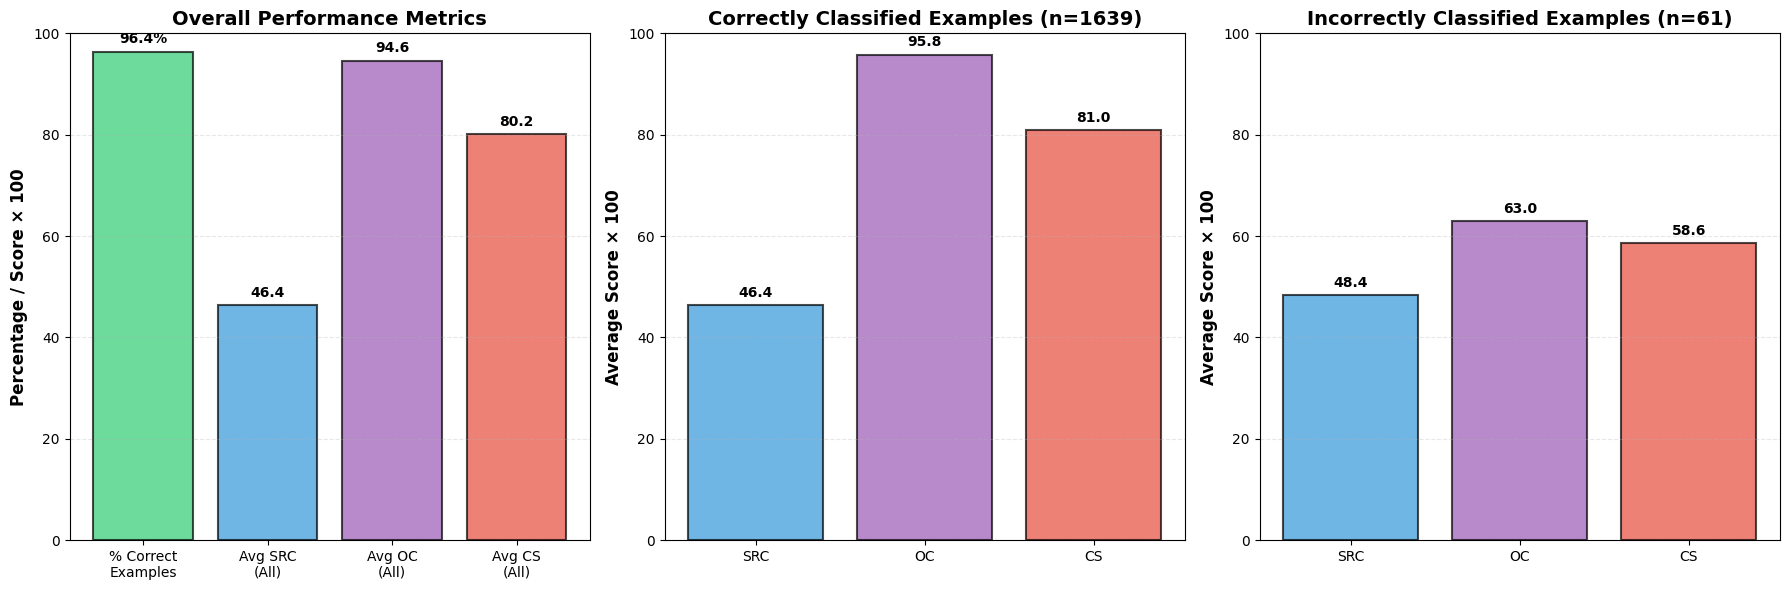

HISTOGRAM SUMMARY STATISTICS

Total Examples: 1700
Correctly Classified: 1639 (96.41%)
Incorrectly Classified: 61 (3.59%)

--------------------------------------------------------------------------------
OVERALL AVERAGES (All Examples):
--------------------------------------------------------------------------------
  Average SRC: 0.4644
  Average OC:  0.9464
  Average CS:  0.8018

--------------------------------------------------------------------------------
CORRECTLY CLASSIFIED EXAMPLES:
--------------------------------------------------------------------------------
  Average SRC: 0.4637
  Average OC:  0.9582
  Average CS:  0.8098

--------------------------------------------------------------------------------
INCORRECTLY CLASSIFIED EXAMPLES:
--------------------------------------------------------------------------------
  Average SRC: 0.4836
  Average OC:  0.6300
  Average CS:  0.5861


In [14]:
# ============================================================================
# CELL 12: Confidence vs Correctness
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

# Extract data from model_outputs - CORRECT DEFINITION OF iscorrect
# An example is correctly classified if generated output matches expected output (sequence_accuracy == 1)
correct_examples = []
incorrect_examples = []

for result in model_outputs:
    generated = result.get('generated', '').lower().strip()
    expected = result.get('expected', '').lower().strip()

    # Correct classification: generated matches expected exactly
    is_correct = (generated == expected)

    if is_correct:
        correct_examples.append(result)
    else:
        incorrect_examples.append(result)

# Calculate overall statistics
total_examples = len(model_outputs)
pct_correct = (len(correct_examples) / total_examples) * 100

# Overall averages (all examples)
avg_src_all = np.mean([x['src'] for x in model_outputs if 'src' in x])
avg_oc_all = np.mean([x['oc'] for x in model_outputs if 'oc' in x])
avg_cs_all = np.mean([x['confidence'] for x in model_outputs if 'confidence' in x])

# Averages for correct examples
avg_src_correct = np.mean([x['src'] for x in correct_examples if 'src' in x]) if correct_examples else 0
avg_oc_correct = np.mean([x['oc'] for x in correct_examples if 'oc' in x]) if correct_examples else 0
avg_cs_correct = np.mean([x['confidence'] for x in correct_examples if 'confidence' in x]) if correct_examples else 0

# Averages for incorrect examples
avg_src_incorrect = np.mean([x['src'] for x in incorrect_examples if 'src' in x]) if incorrect_examples else 0
avg_oc_incorrect = np.mean([x['oc'] for x in incorrect_examples if 'oc' in x]) if incorrect_examples else 0
avg_cs_incorrect = np.mean([x['confidence'] for x in incorrect_examples if 'confidence' in x]) if incorrect_examples else 0

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Overall Statistics
ax1 = axes[0]
categories_1 = ['% Correct\nExamples', 'Avg SRC\n(All)', 'Avg OC\n(All)', 'Avg CS\n(All)']
values_1 = [pct_correct, avg_src_all * 100, avg_oc_all * 100, avg_cs_all * 100]
colors_1 = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']

bars1 = ax1.bar(categories_1, values_1, color=colors_1, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Percentage / Score × 100', fontsize=12, fontweight='bold')
ax1.set_title('Overall Performance Metrics', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, val in zip(bars1, values_1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{val:.1f}%' if val == pct_correct else f'{val:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Correctly Classified Examples
ax2 = axes[1]
if len(correct_examples) > 0:
    categories_2 = ['SRC', 'OC', 'CS']
    values_2 = [avg_src_correct * 100, avg_oc_correct * 100, avg_cs_correct * 100]
    colors_2 = ['#3498db', '#9b59b6', '#e74c3c']

    bars2 = ax2.bar(categories_2, values_2, color=colors_2, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Average Score × 100', fontsize=12, fontweight='bold')
    ax2.set_title(f'Correctly Classified Examples (n={len(correct_examples)})', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')

    # Add value labels on bars
    for bar, val in zip(bars2, values_2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{val:.1f}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'No Correct\nExamples',
             ha='center', va='center', fontsize=14, fontweight='bold',
             transform=ax2.transAxes)
    ax2.set_title('Correctly Classified Examples (n=0)', fontsize=14, fontweight='bold')

# Plot 3: Incorrectly Classified Examples
ax3 = axes[2]
if len(incorrect_examples) > 0:
    categories_3 = ['SRC', 'OC', 'CS']
    values_3 = [avg_src_incorrect * 100, avg_oc_incorrect * 100, avg_cs_incorrect * 100]
    colors_3 = ['#3498db', '#9b59b6', '#e74c3c']

    bars3 = ax3.bar(categories_3, values_3, color=colors_3, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax3.set_ylabel('Average Score × 100', fontsize=12, fontweight='bold')
    ax3.set_title(f'Incorrectly Classified Examples (n={len(incorrect_examples)})', fontsize=14, fontweight='bold')
    ax3.set_ylim(0, 100)
    ax3.grid(axis='y', alpha=0.3, linestyle='--')

    # Add value labels on bars
    for bar, val in zip(bars3, values_3):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{val:.1f}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'No Incorrect\nExamples',
             ha='center', va='center', fontsize=14, fontweight='bold',
             transform=ax3.transAxes)
    ax3.set_title('Incorrectly Classified Examples (n=0)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*80)
print("HISTOGRAM SUMMARY STATISTICS")
print("="*80)
print(f"\nTotal Examples: {total_examples}")
print(f"Correctly Classified: {len(correct_examples)} ({pct_correct:.2f}%)")
print(f"Incorrectly Classified: {len(incorrect_examples)} ({100-pct_correct:.2f}%)")
print("\n" + "-"*80)
print("OVERALL AVERAGES (All Examples):")
print("-"*80)
print(f"  Average SRC: {avg_src_all:.4f}")
print(f"  Average OC:  {avg_oc_all:.4f}")
print(f"  Average CS:  {avg_cs_all:.4f}")

if correct_examples:
    print("\n" + "-"*80)
    print("CORRECTLY CLASSIFIED EXAMPLES:")
    print("-"*80)
    print(f"  Average SRC: {avg_src_correct:.4f}")
    print(f"  Average OC:  {avg_oc_correct:.4f}")
    print(f"  Average CS:  {avg_cs_correct:.4f}")

if incorrect_examples:
    print("\n" + "-"*80)
    print("INCORRECTLY CLASSIFIED EXAMPLES:")
    print("-"*80)
    print(f"  Average SRC: {avg_src_incorrect:.4f}")
    print(f"  Average OC:  {avg_oc_incorrect:.4f}")
    print(f"  Average CS:  {avg_cs_incorrect:.4f}")
print("="*80)

# ============================================================================

CREATING VISUALIZATIONS FOR 24 BATCHES

Processing Batch 1/24: 84 examples


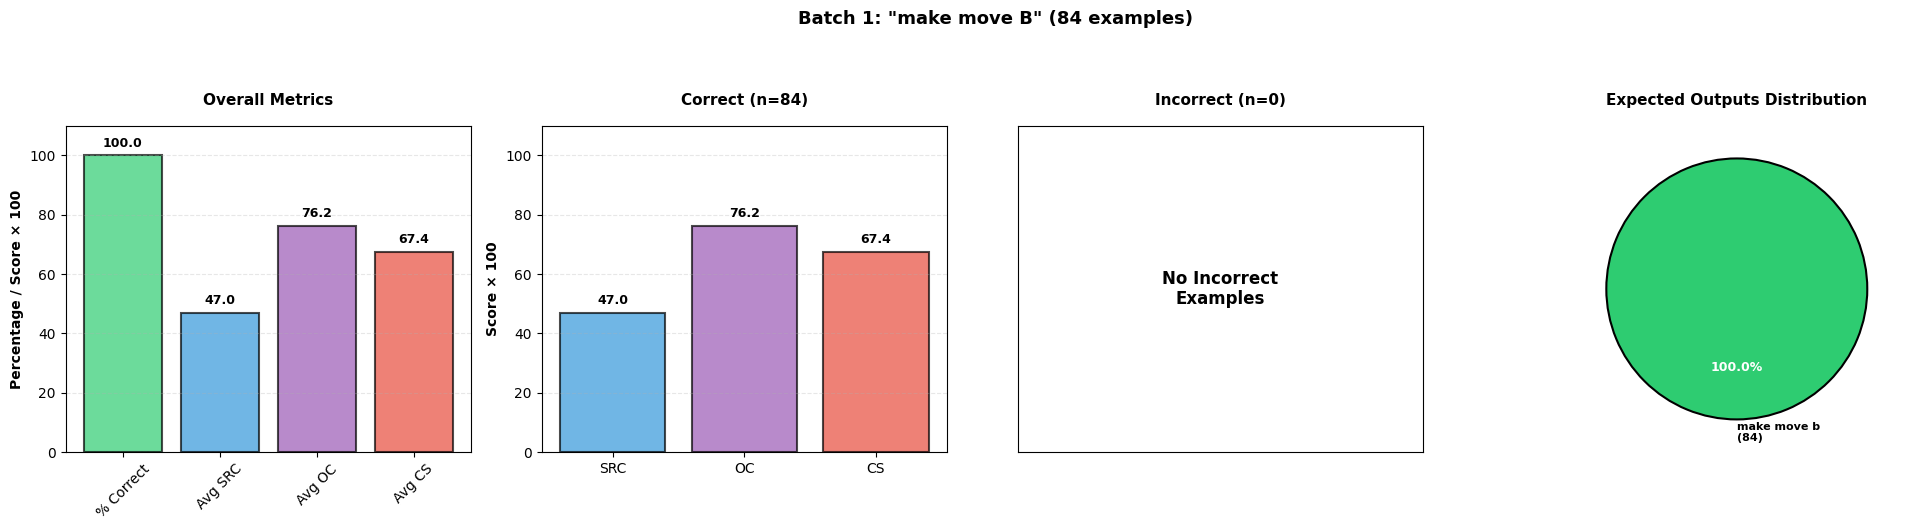

  ✓ Correct: 84/84 (100.0%)
  ✗ Incorrect: 0/84 (0.0%)
  Expected outputs: 1 unique

Processing Batch 2/24: 102 examples


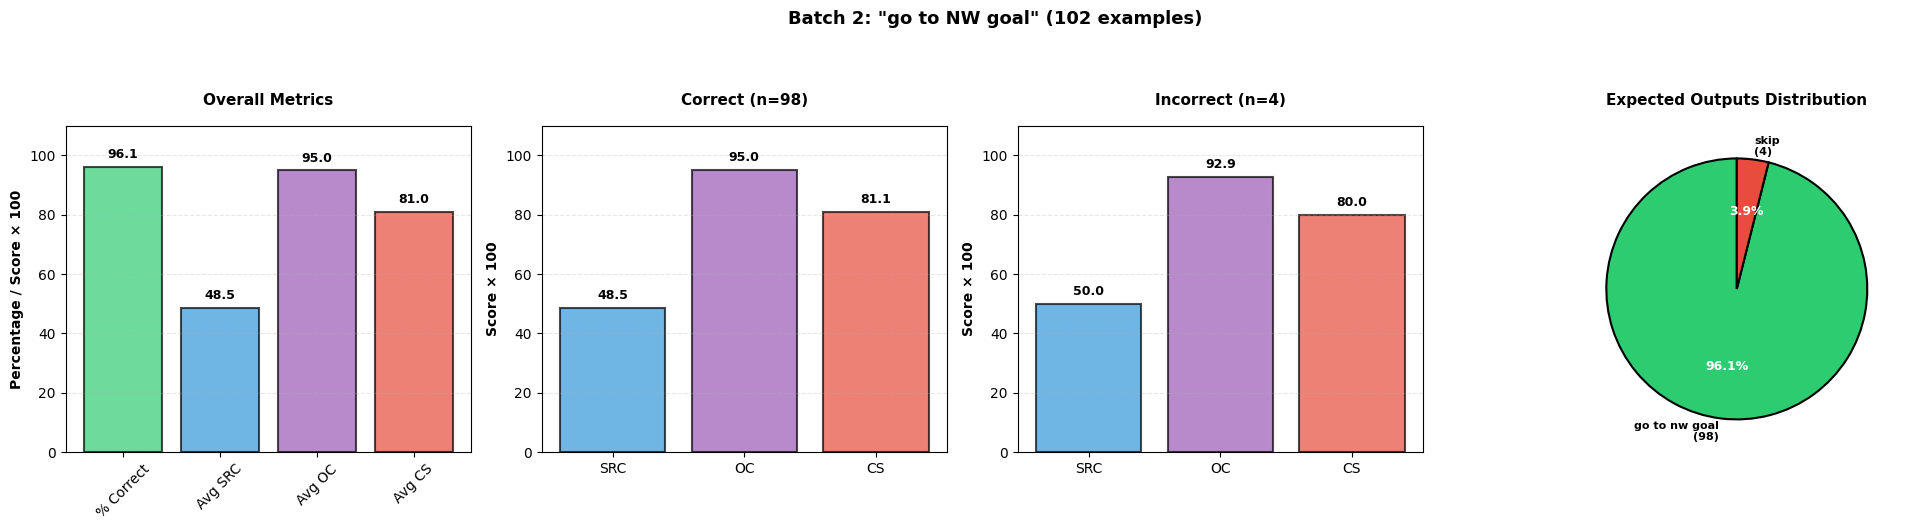

  ✓ Correct: 98/102 (96.1%)
  ✗ Incorrect: 4/102 (3.9%)
  Expected outputs: 2 unique

Processing Batch 3/24: 95 examples


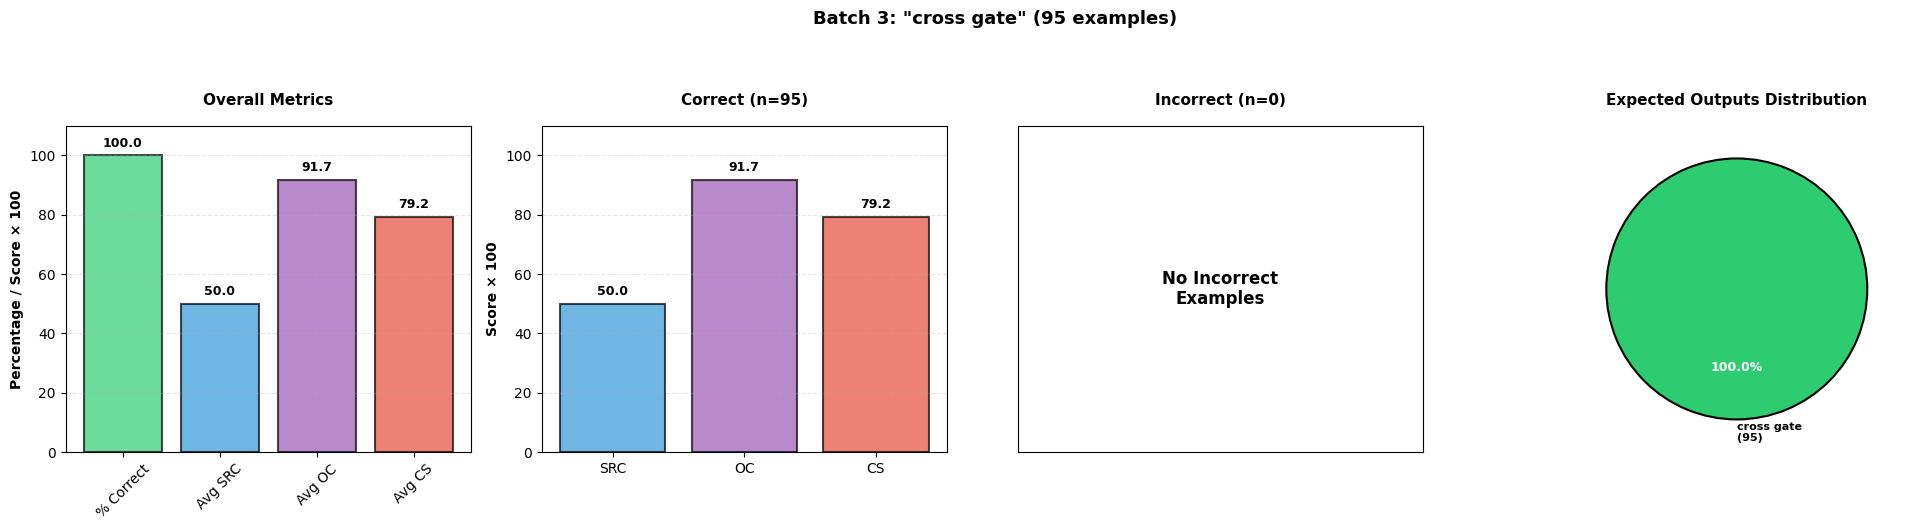

  ✓ Correct: 95/95 (100.0%)
  ✗ Incorrect: 0/95 (0.0%)
  Expected outputs: 1 unique

Processing Batch 4/24: 101 examples


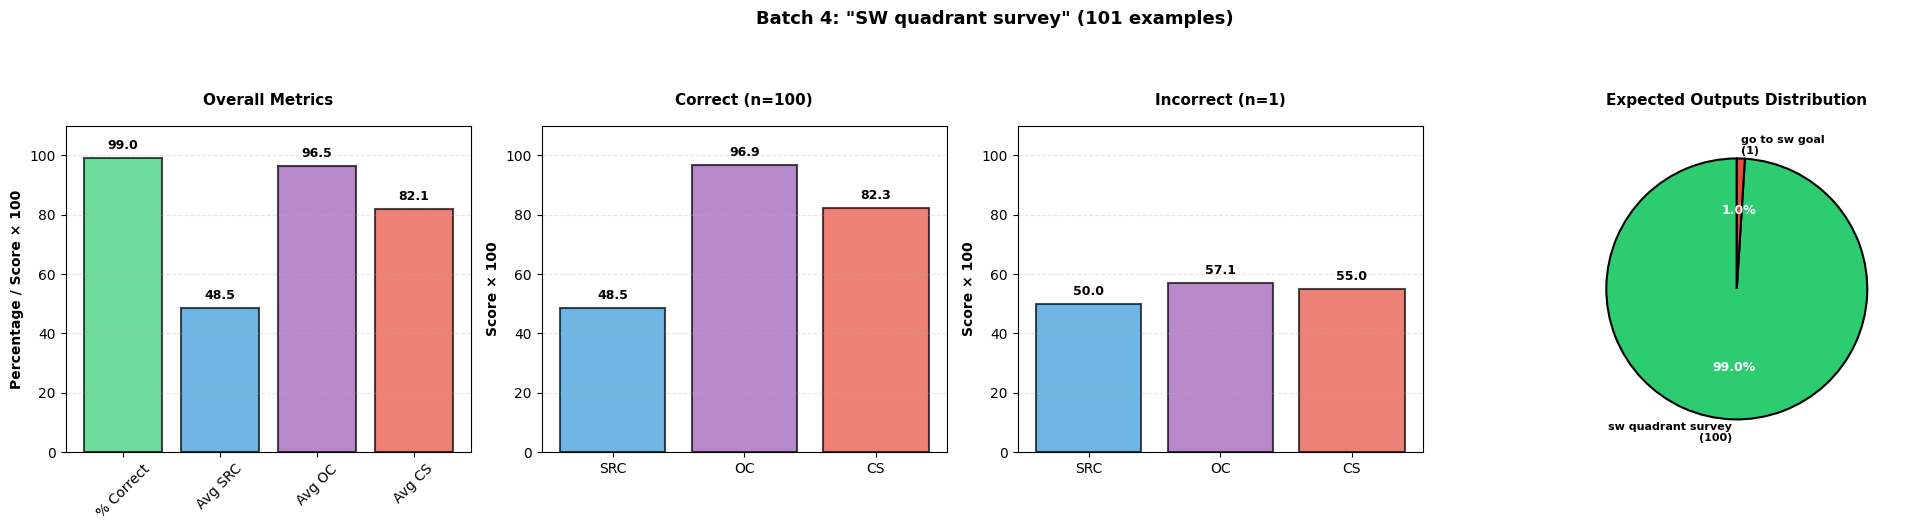

  ✓ Correct: 100/101 (99.0%)
  ✗ Incorrect: 1/101 (1.0%)
  Expected outputs: 2 unique

Processing Batch 5/24: 113 examples


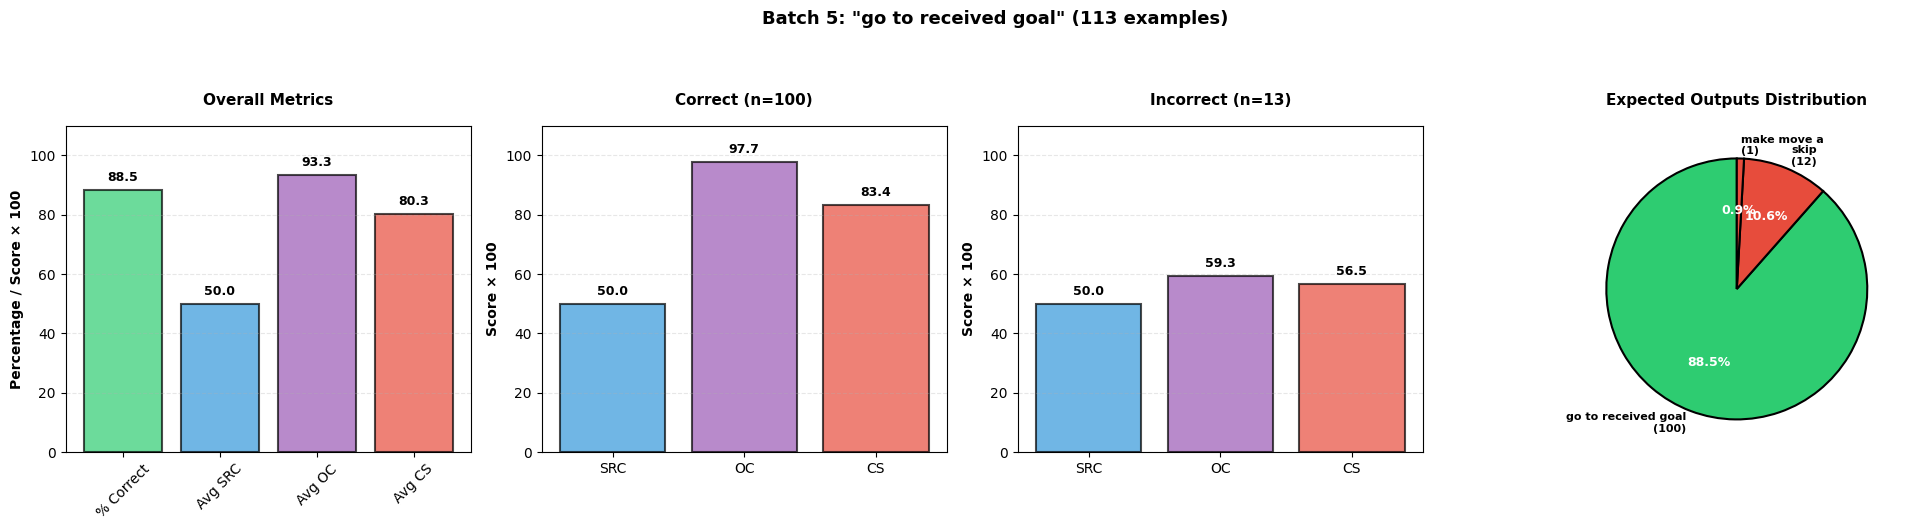

  ✓ Correct: 100/113 (88.5%)
  ✗ Incorrect: 13/113 (11.5%)
  Expected outputs: 3 unique

Processing Batch 6/24: 99 examples


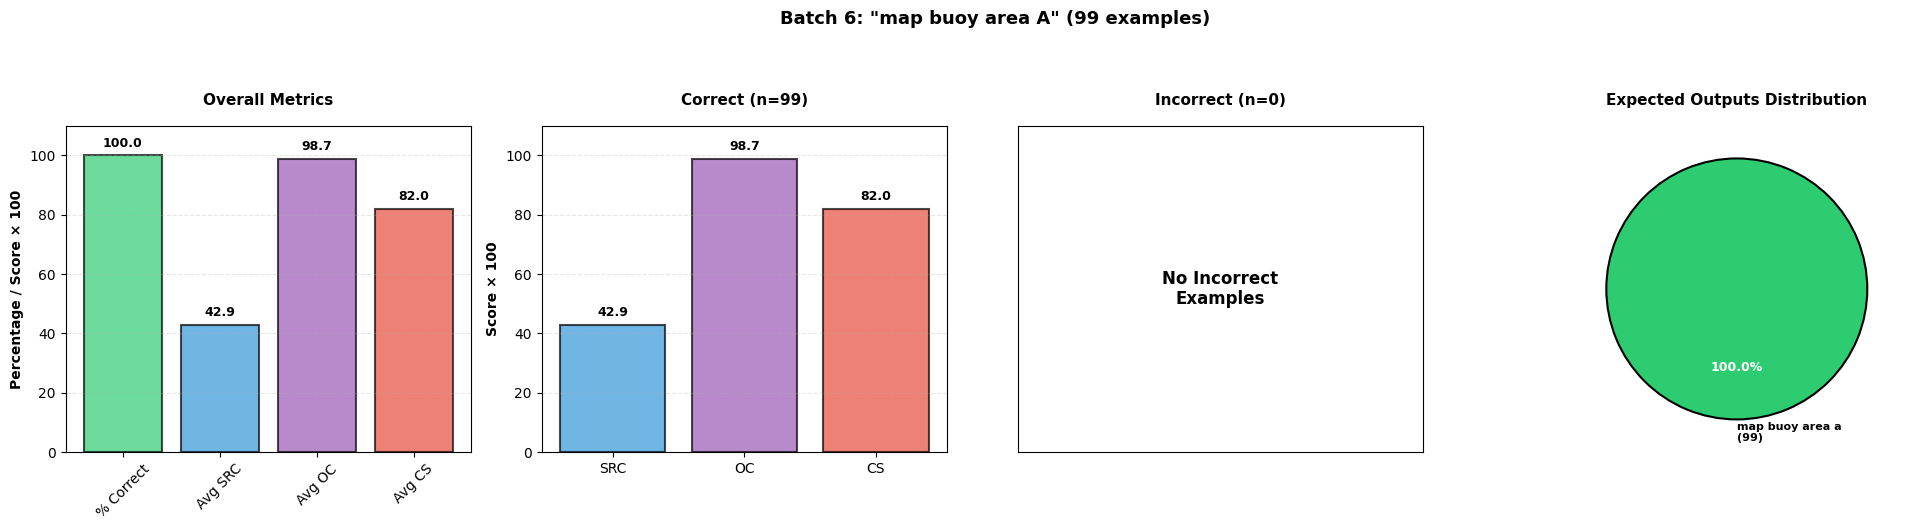

  ✓ Correct: 99/99 (100.0%)
  ✗ Incorrect: 0/99 (0.0%)
  Expected outputs: 1 unique

Processing Batch 7/24: 114 examples


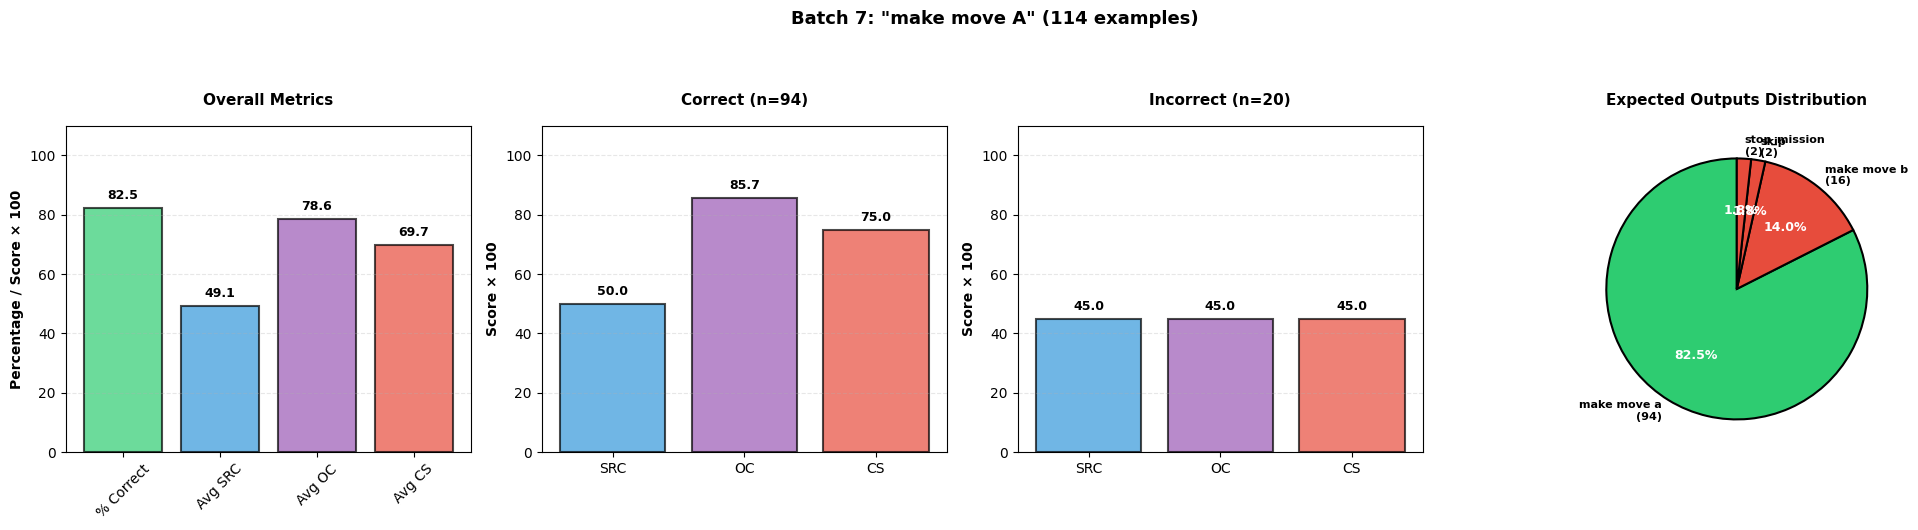

  ✓ Correct: 94/114 (82.5%)
  ✗ Incorrect: 20/114 (17.5%)
  Expected outputs: 4 unique

Processing Batch 8/24: 100 examples


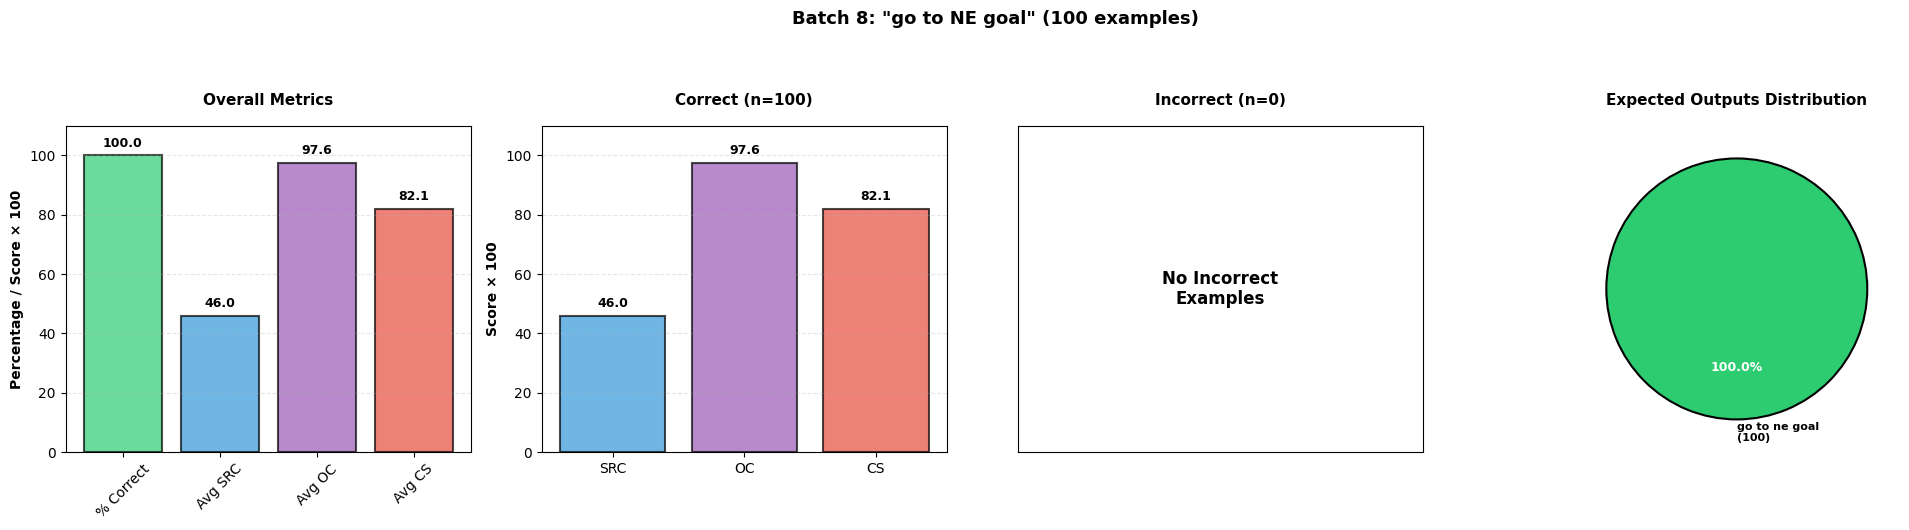

  ✓ Correct: 100/100 (100.0%)
  ✗ Incorrect: 0/100 (0.0%)
  Expected outputs: 1 unique

Processing Batch 9/24: 100 examples


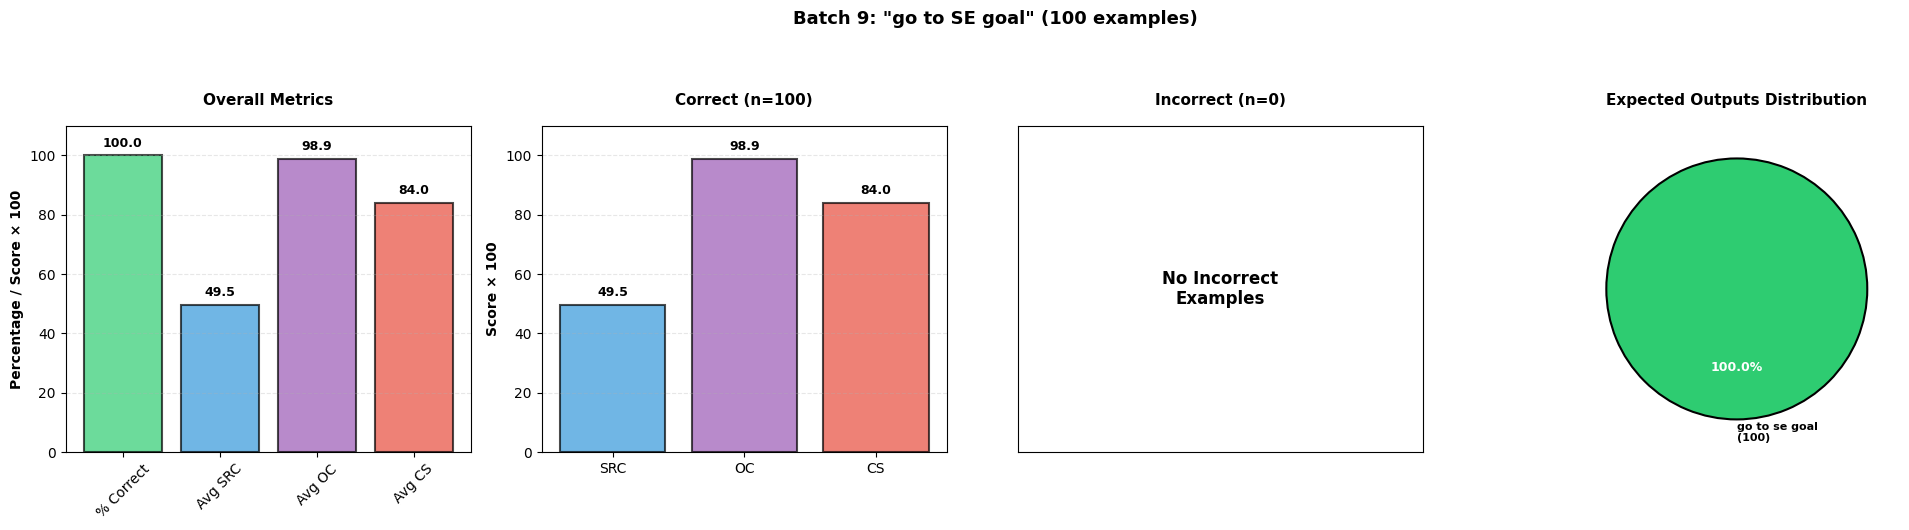

  ✓ Correct: 100/100 (100.0%)
  ✗ Incorrect: 0/100 (0.0%)
  Expected outputs: 1 unique

Processing Batch 10/24: 99 examples


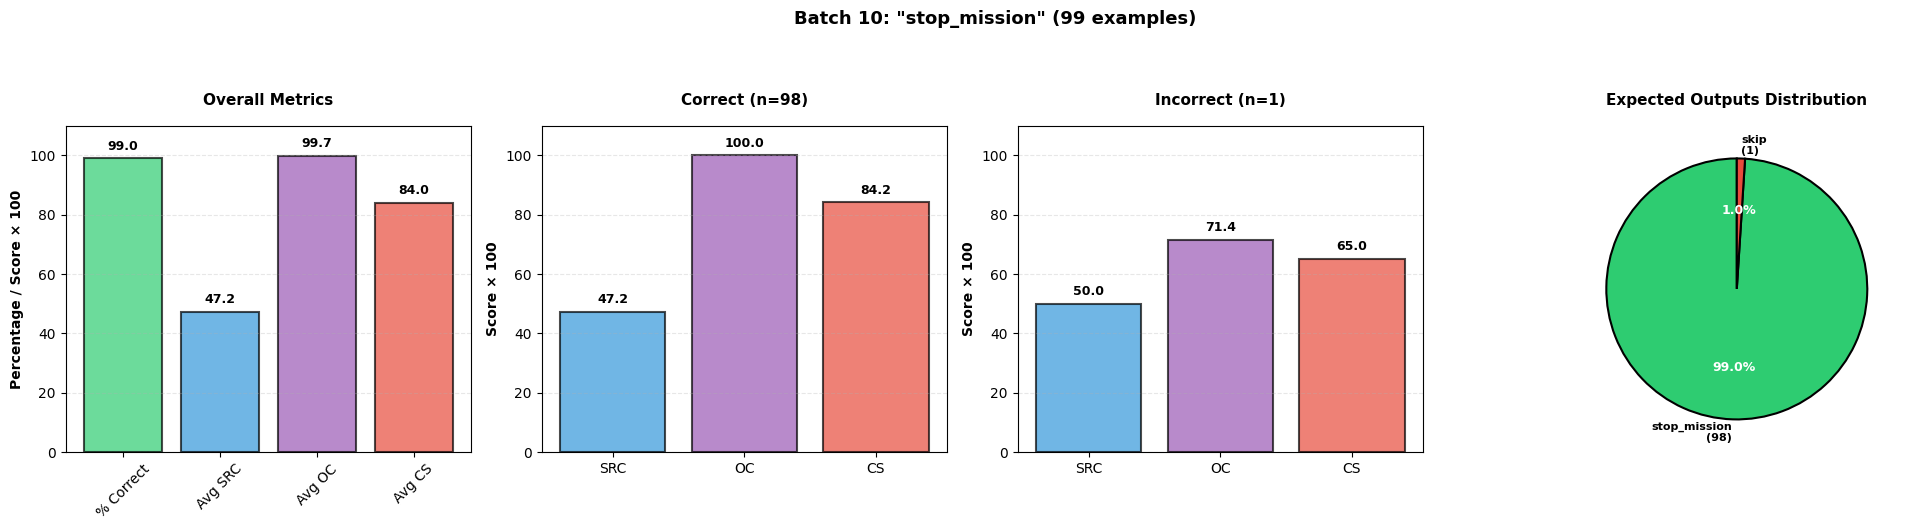

  ✓ Correct: 98/99 (99.0%)
  ✗ Incorrect: 1/99 (1.0%)
  Expected outputs: 2 unique

Processing Batch 11/24: 1 examples


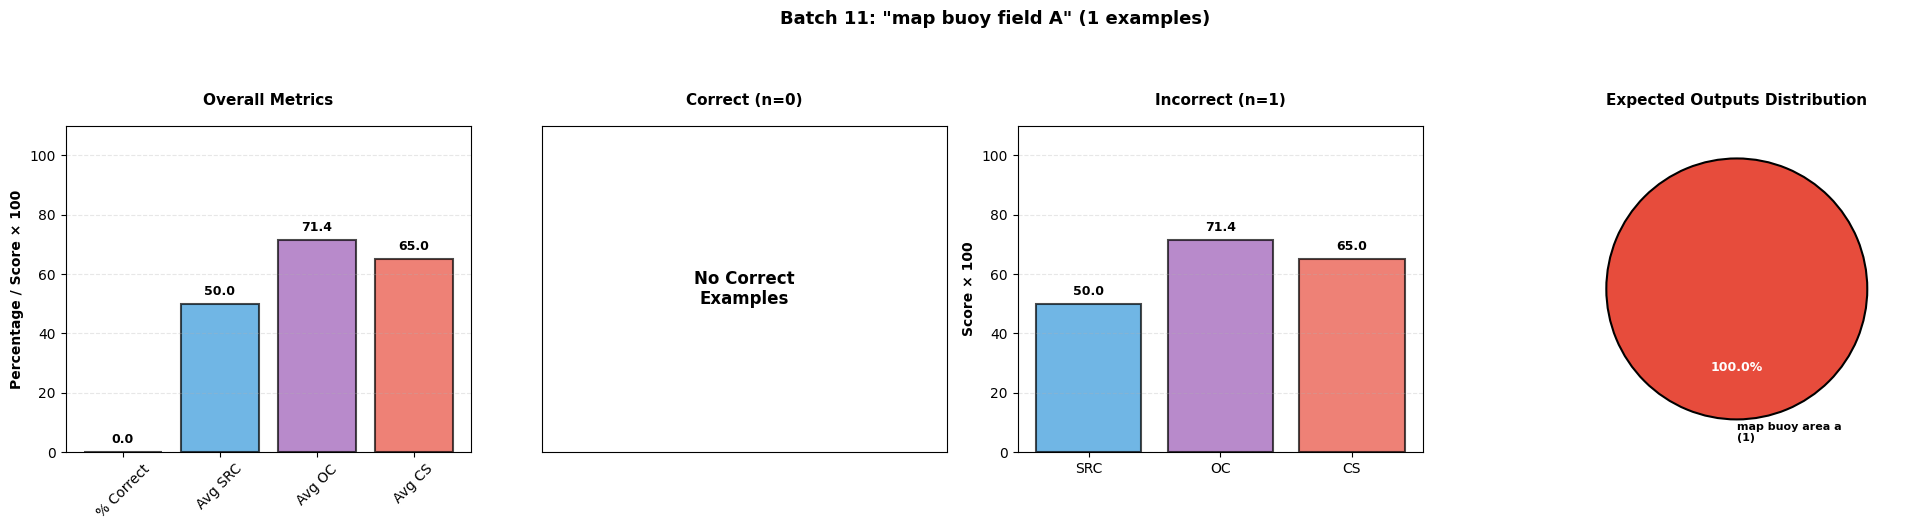

  ✓ Correct: 0/1 (0.0%)
  ✗ Incorrect: 1/1 (100.0%)
  Expected outputs: 1 unique

Processing Batch 12/24: 81 examples


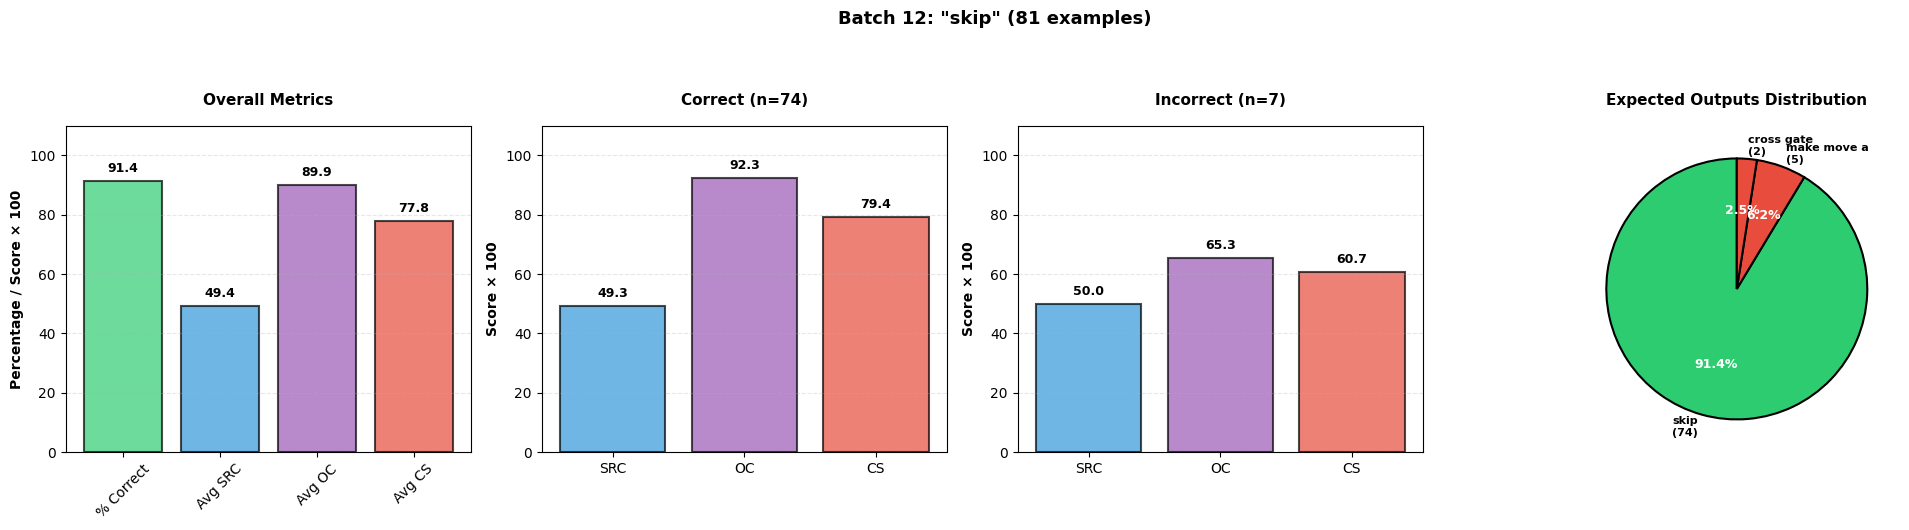

  ✓ Correct: 74/81 (91.4%)
  ✗ Incorrect: 7/81 (8.6%)
  Expected outputs: 3 unique

Processing Batch 13/24: 102 examples


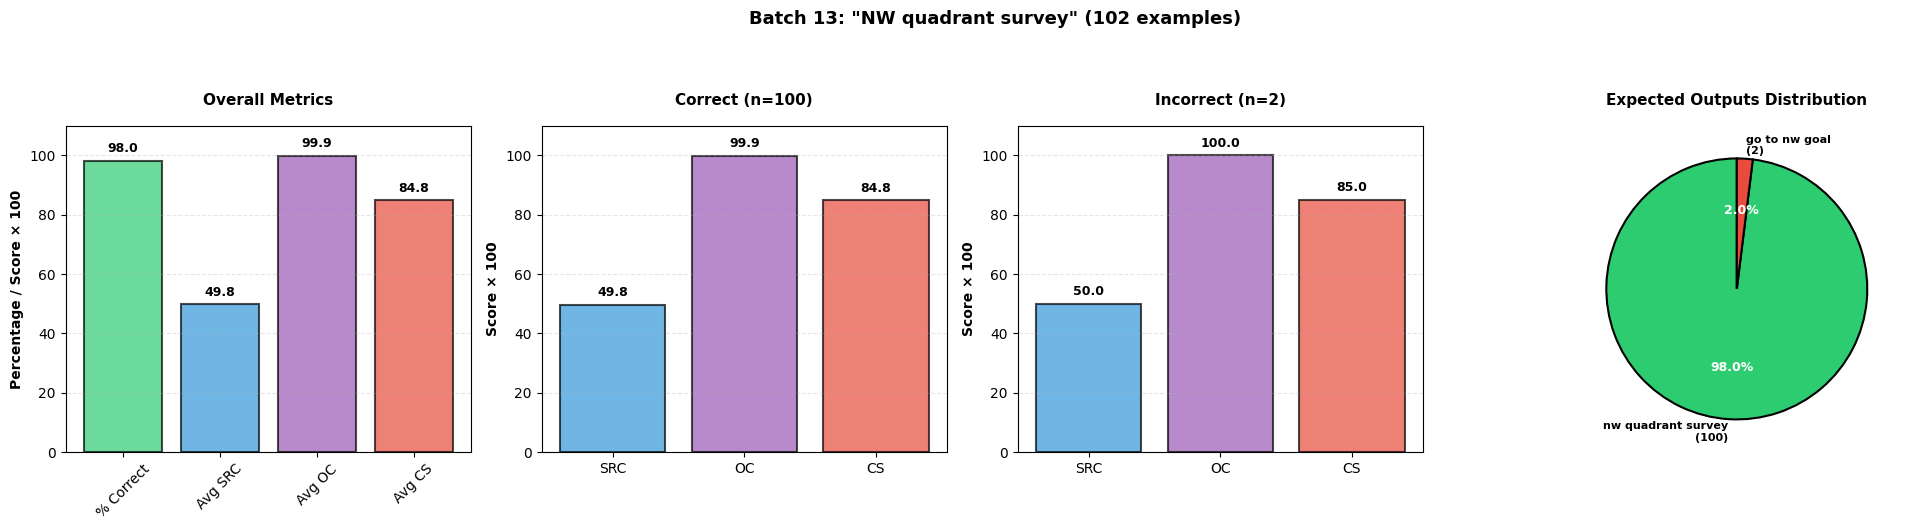

  ✓ Correct: 100/102 (98.0%)
  ✗ Incorrect: 2/102 (2.0%)
  Expected outputs: 2 unique

Processing Batch 14/24: 99 examples


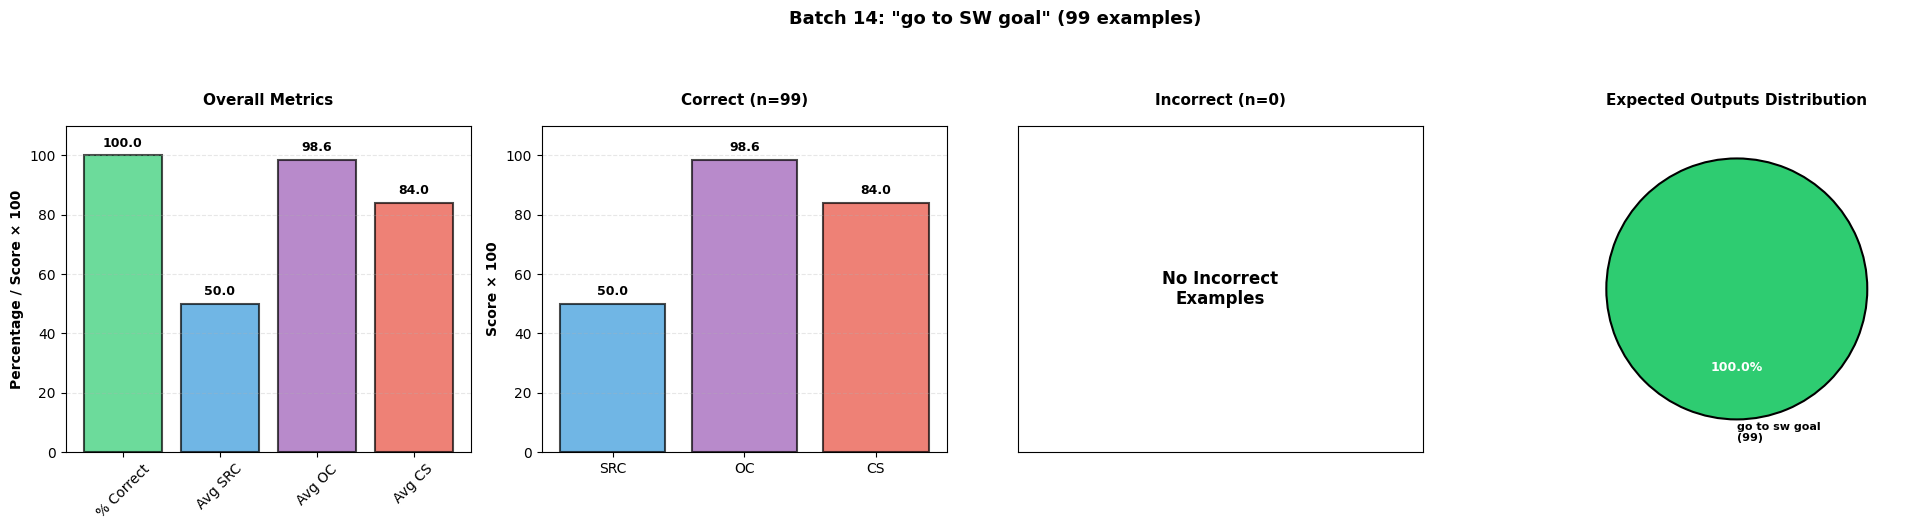

  ✓ Correct: 99/99 (100.0%)
  ✗ Incorrect: 0/99 (0.0%)
  Expected outputs: 1 unique

Processing Batch 15/24: 99 examples


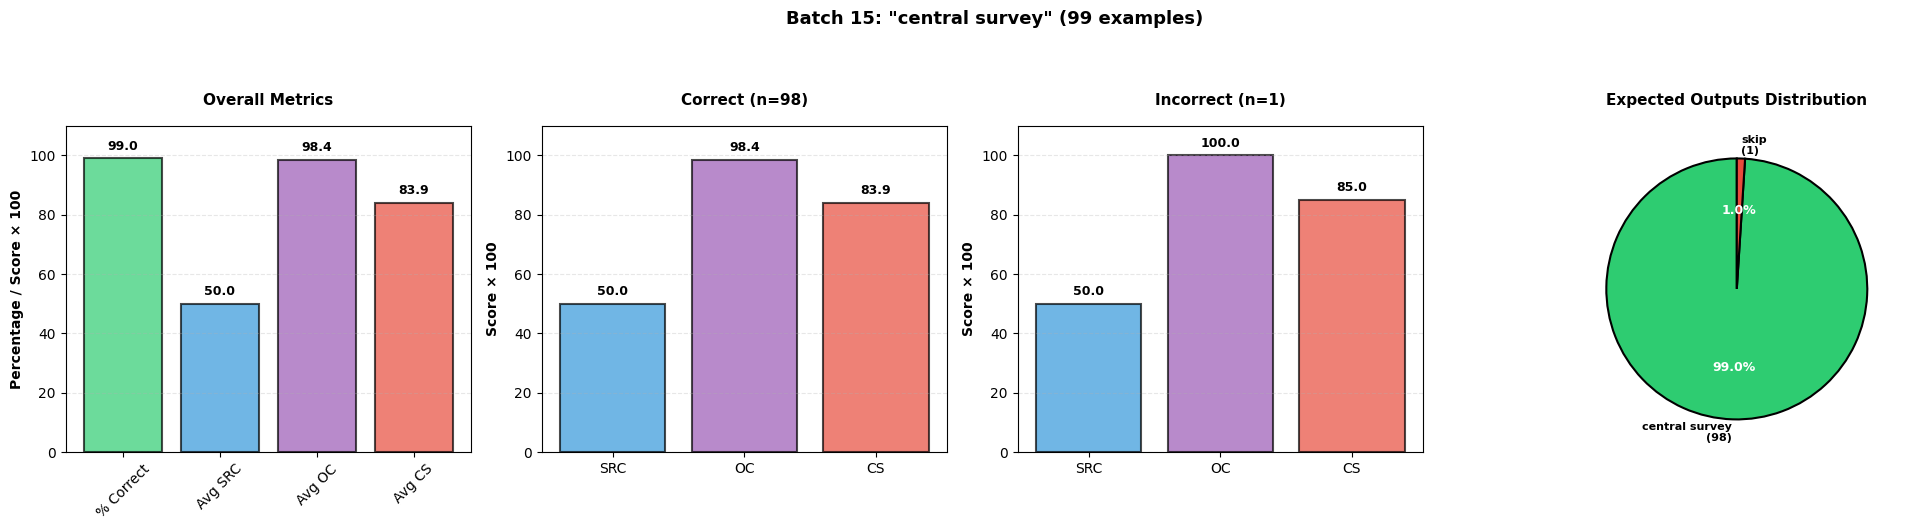

  ✓ Correct: 98/99 (99.0%)
  ✗ Incorrect: 1/99 (1.0%)
  Expected outputs: 2 unique

Processing Batch 16/24: 100 examples


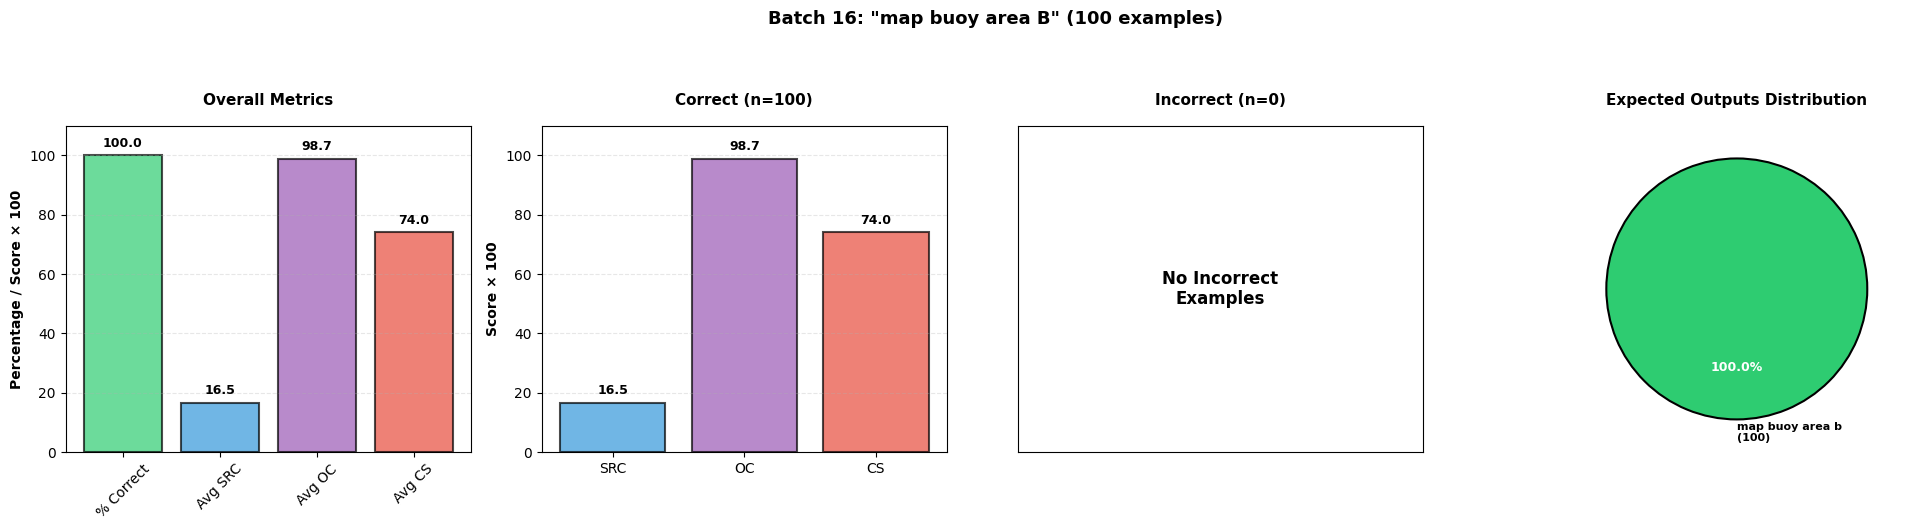

  ✓ Correct: 100/100 (100.0%)
  ✗ Incorrect: 0/100 (0.0%)
  Expected outputs: 1 unique

Processing Batch 17/24: 100 examples


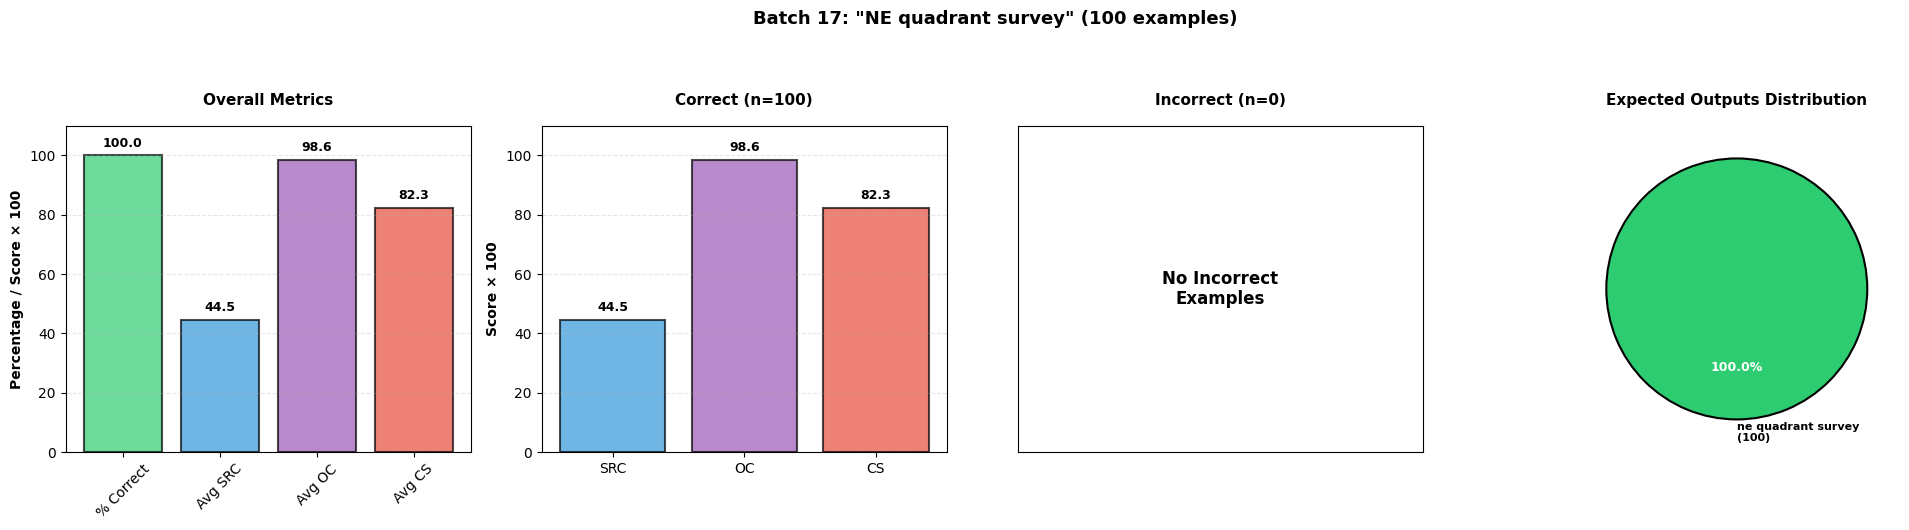

  ✓ Correct: 100/100 (100.0%)
  ✗ Incorrect: 0/100 (0.0%)
  Expected outputs: 1 unique

Processing Batch 18/24: 104 examples


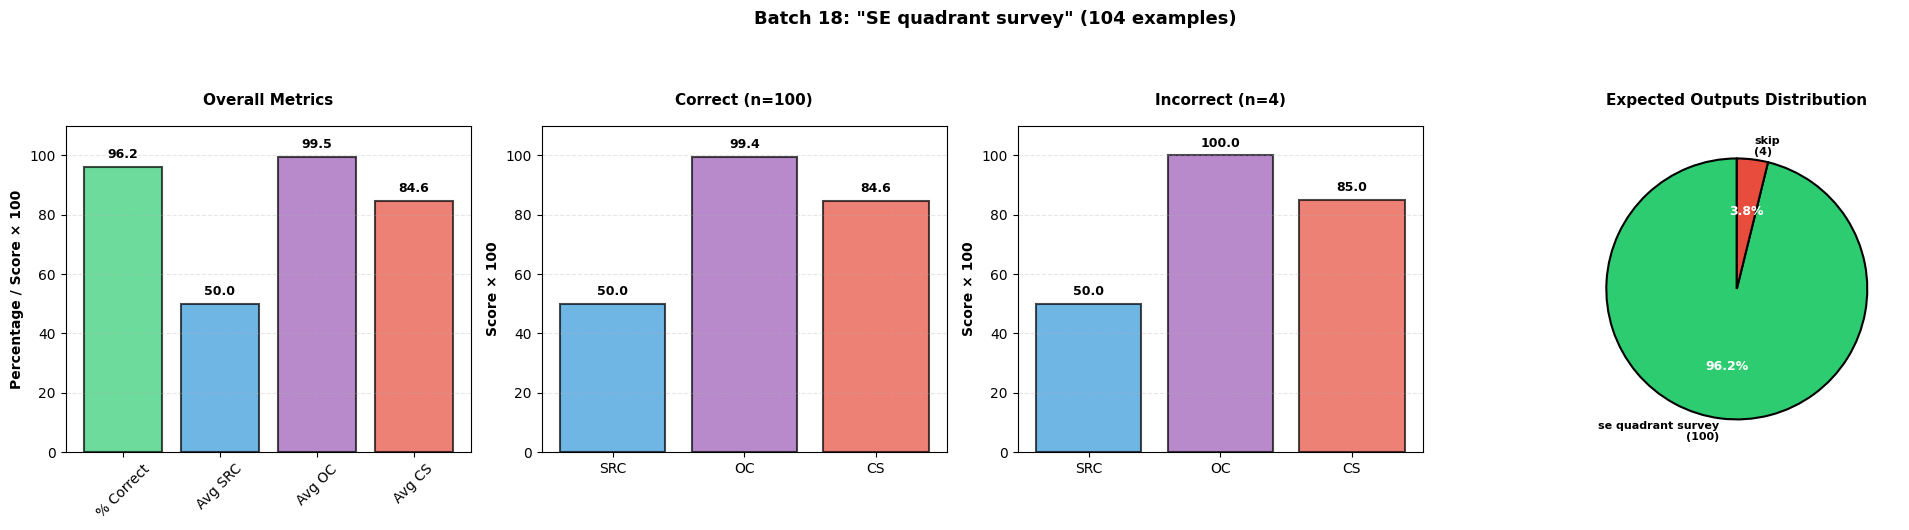

  ✓ Correct: 100/104 (96.2%)
  ✗ Incorrect: 4/104 (3.8%)
  Expected outputs: 2 unique

Processing Batch 19/24: 1 examples


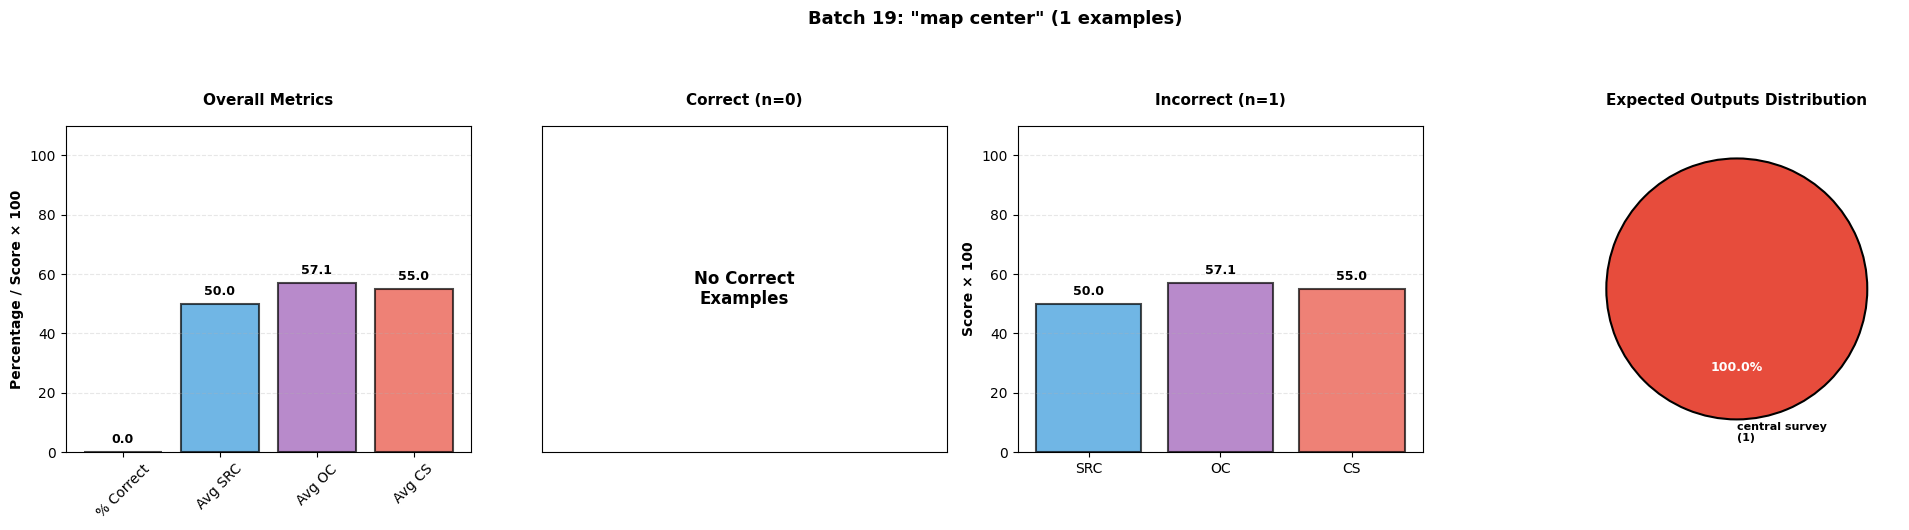

  ✓ Correct: 0/1 (0.0%)
  ✗ Incorrect: 1/1 (100.0%)
  Expected outputs: 1 unique

Processing Batch 20/24: 2 examples


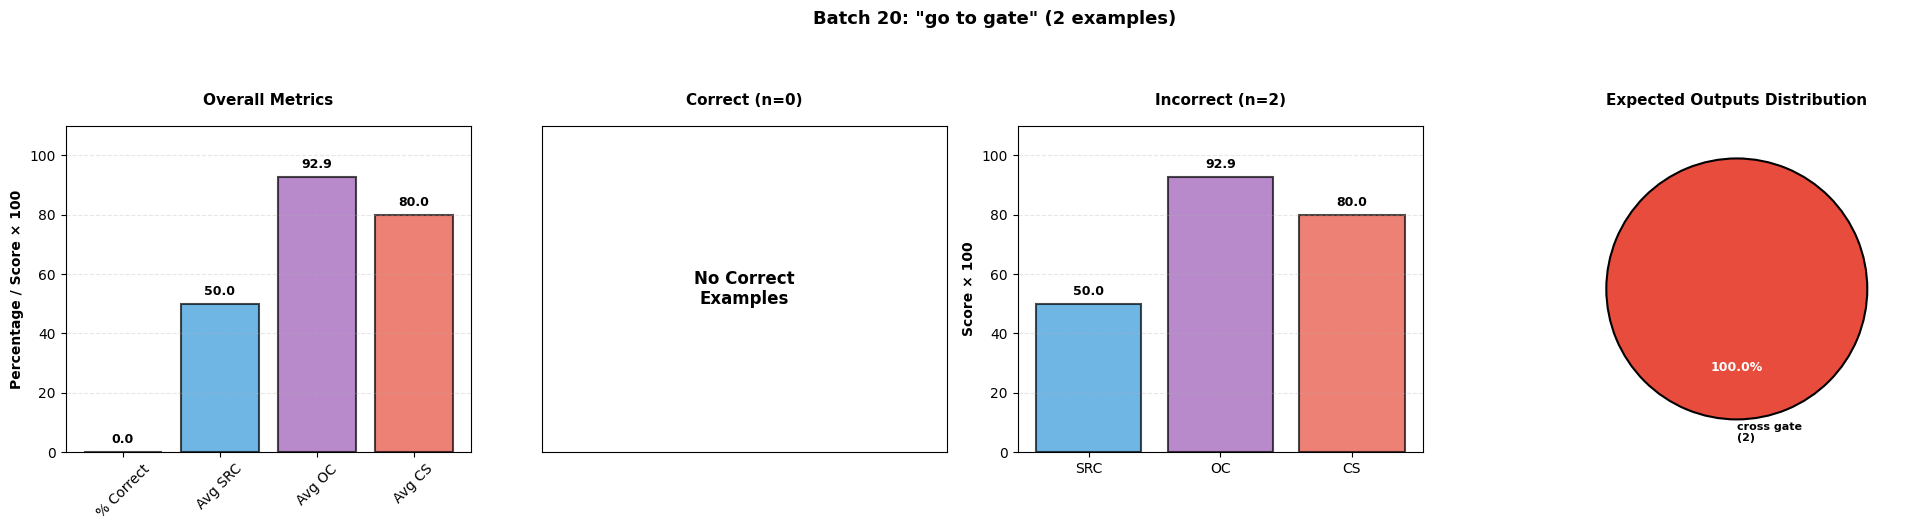

  ✓ Correct: 0/2 (0.0%)
  ✗ Incorrect: 2/2 (100.0%)
  Expected outputs: 1 unique

Processing Batch 21/24: 1 examples


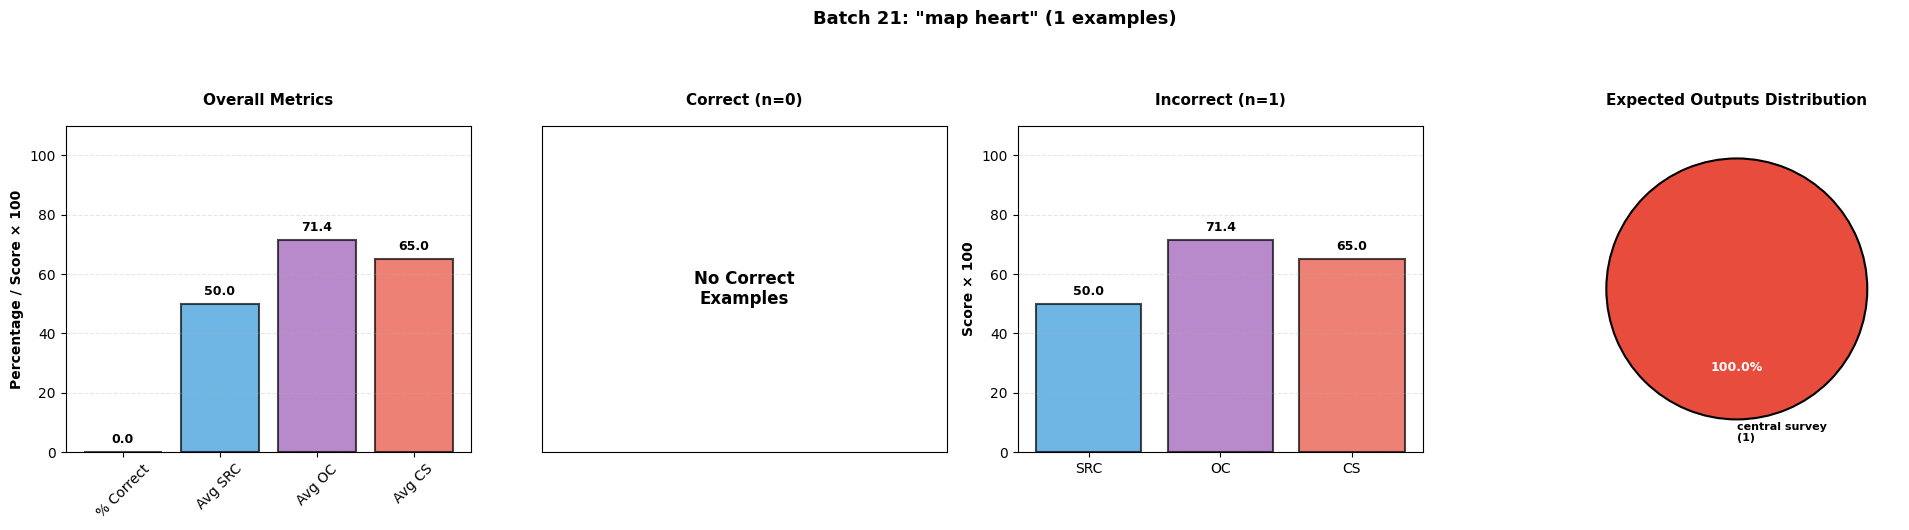

  ✓ Correct: 0/1 (0.0%)
  ✗ Incorrect: 1/1 (100.0%)
  Expected outputs: 1 unique

Processing Batch 22/24: 1 examples


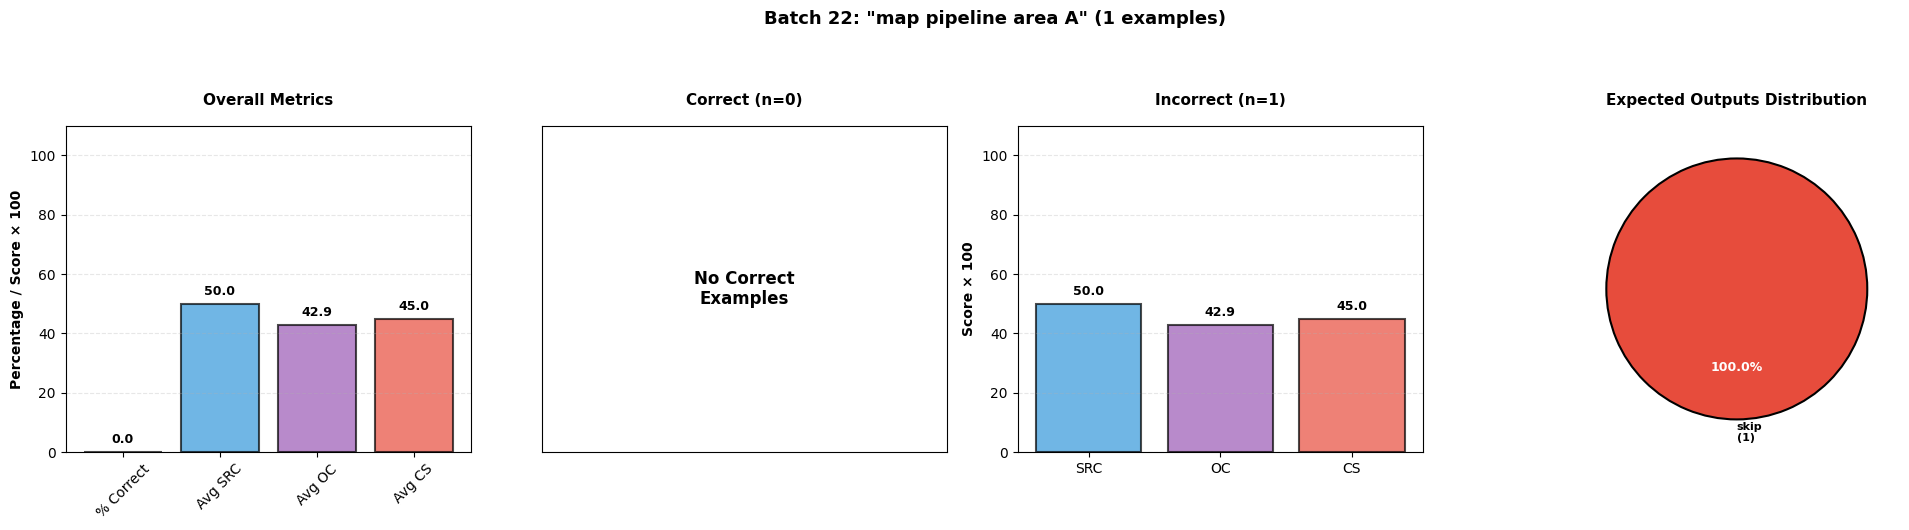

  ✓ Correct: 0/1 (0.0%)
  ✗ Incorrect: 1/1 (100.0%)
  Expected outputs: 1 unique

Processing Batch 23/24: 1 examples


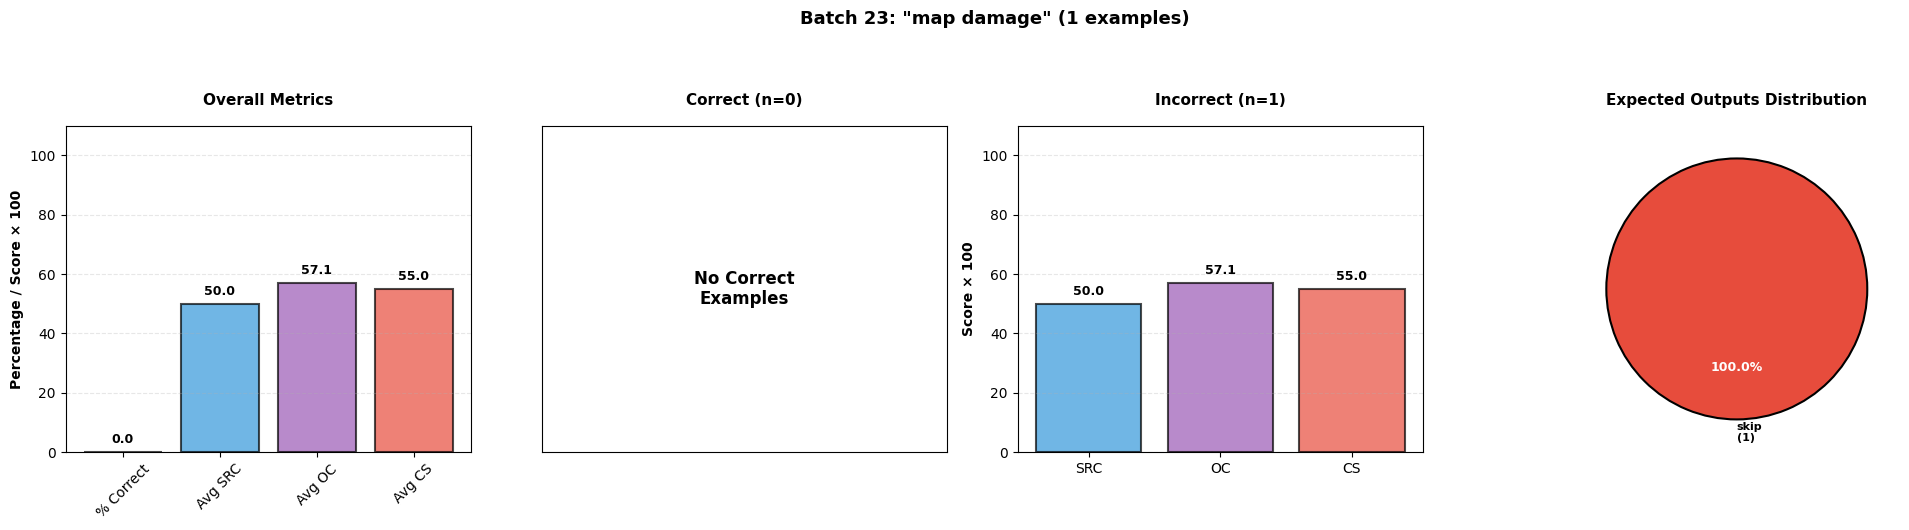

  ✓ Correct: 0/1 (0.0%)
  ✗ Incorrect: 1/1 (100.0%)
  Expected outputs: 1 unique

Processing Batch 24/24: 1 examples


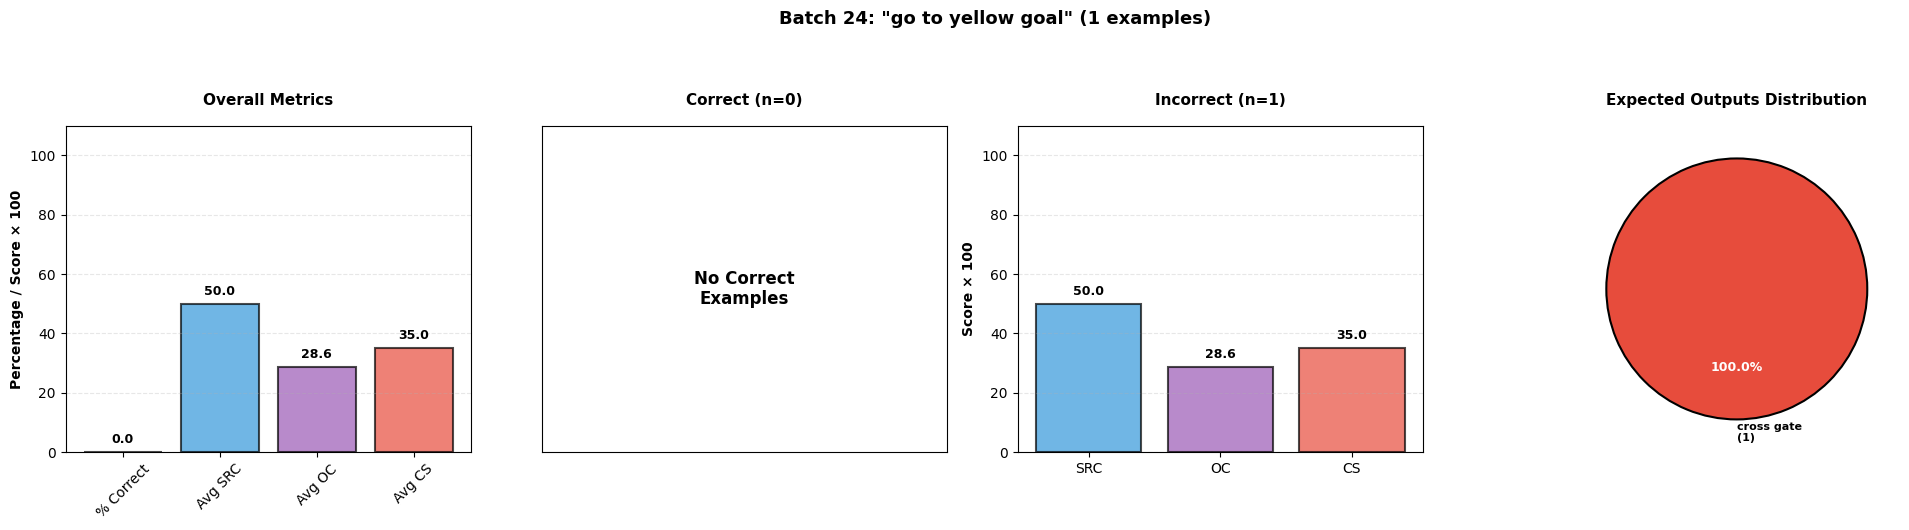

  ✓ Correct: 0/1 (0.0%)
  ✗ Incorrect: 1/1 (100.0%)
  Expected outputs: 1 unique

BATCH VISUALIZATION COMPLETE


In [15]:
# ============================================================================
# CELL 13: Confidence vs Correctness per batch
# ============================================================================

# Group examples by batch (same generated output)
batch_groups = defaultdict(list)
for idx, result in enumerate(model_outputs):
    generated = result.get('generated', '')
    batch_groups[generated].append(idx)

print("="*80)
print(f"CREATING VISUALIZATIONS FOR {len(batch_groups)} BATCHES")
print("="*80)

# Iterate through each batch
for batch_idx, (output, example_indices) in enumerate(batch_groups.items(), 1):
    print(f"\nProcessing Batch {batch_idx}/{len(batch_groups)}: {len(example_indices)} examples")

    # Collect data for this batch - CORRECT DEFINITION OF CORRECTNESS
    correct_examples = []
    incorrect_examples = []
    expected_outputs = defaultdict(lambda: {'count': 0, 'is_correct': False})

    for ex_idx in example_indices:
        result = model_outputs[ex_idx]
        generated = result.get('generated', '').lower().strip()
        expected = result.get('expected', '').lower().strip()

        # Correct classification: generated matches expected exactly
        is_correct = (generated == expected)

        # Track expected outputs for pie chart
        if is_correct:
            expected_outputs[expected]['is_correct'] = True
        expected_outputs[expected]['count'] += 1

        if is_correct:
            correct_examples.append(result)
        else:
            incorrect_examples.append(result)

    # Calculate statistics for the batch
    total_examples = len(example_indices)
    pct_correct = (len(correct_examples) / total_examples) * 100

    # Overall averages (all examples in batch)
    all_src = [x['src'] for x in [model_outputs[i] for i in example_indices] if 'src' in x]
    all_oc = [x['oc'] for x in [model_outputs[i] for i in example_indices] if 'oc' in x]
    all_cs = [x['confidence'] for x in [model_outputs[i] for i in example_indices] if 'confidence' in x]

    avg_src_all = np.mean(all_src) if all_src else 0
    avg_oc_all = np.mean(all_oc) if all_oc else 0
    avg_cs_all = np.mean(all_cs) if all_cs else 0

    # Averages for correct examples in batch
    correct_src = [x['src'] for x in correct_examples if 'src' in x]
    correct_oc = [x['oc'] for x in correct_examples if 'oc' in x]
    correct_cs = [x['confidence'] for x in correct_examples if 'confidence' in x]

    avg_src_correct = np.mean(correct_src) if correct_src else 0
    avg_oc_correct = np.mean(correct_oc) if correct_oc else 0
    avg_cs_correct = np.mean(correct_cs) if correct_cs else 0

    # Averages for incorrect examples in batch
    incorrect_src = [x['src'] for x in incorrect_examples if 'src' in x]
    incorrect_oc = [x['oc'] for x in incorrect_examples if 'oc' in x]
    incorrect_cs = [x['confidence'] for x in incorrect_examples if 'confidence' in x]

    avg_src_incorrect = np.mean(incorrect_src) if incorrect_src else 0
    avg_oc_incorrect = np.mean(incorrect_oc) if incorrect_oc else 0
    avg_cs_incorrect = np.mean(incorrect_cs) if incorrect_cs else 0

    # Create figure with 4 subplots (3 histograms + 1 pie chart)
    fig = plt.figure(figsize=(20, 5))
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 1.2])

    # Plot 1: Overall Statistics
    ax1 = fig.add_subplot(gs[0])
    categories_1 = ['% Correct', 'Avg SRC', 'Avg OC', 'Avg CS']
    values_1 = [pct_correct, avg_src_all * 100, avg_oc_all * 100, avg_cs_all * 100]
    colors_1 = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']

    bars1 = ax1.bar(categories_1, values_1, color=colors_1, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax1.set_ylabel('Percentage / Score × 100', fontsize=10, fontweight='bold')
    ax1.set_title('Overall Metrics', fontsize=11, fontweight='bold', pad=15)
    ax1.set_ylim(0, 110)  # Extra space to prevent overlap
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.tick_params(axis='x', rotation=45)

    for bar, val in zip(bars1, values_1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{val:.1f}',
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Plot 2: Correctly Classified Examples
    ax2 = fig.add_subplot(gs[1])
    if len(correct_examples) > 0:
        categories_2 = ['SRC', 'OC', 'CS']
        values_2 = [avg_src_correct * 100, avg_oc_correct * 100, avg_cs_correct * 100]
        colors_2 = ['#3498db', '#9b59b6', '#e74c3c']

        bars2 = ax2.bar(categories_2, values_2, color=colors_2, alpha=0.7, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Score × 100', fontsize=10, fontweight='bold')
        ax2.set_title(f'Correct (n={len(correct_examples)})', fontsize=11, fontweight='bold', pad=15)
        ax2.set_ylim(0, 110)  # Extra space to prevent overlap
        ax2.grid(axis='y', alpha=0.3, linestyle='--')

        for bar, val in zip(bars2, values_2):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                     f'{val:.1f}',
                     ha='center', va='bottom', fontsize=9, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No Correct\nExamples',
                 ha='center', va='center', fontsize=12, fontweight='bold',
                 transform=ax2.transAxes)
        ax2.set_title(f'Correct (n=0)', fontsize=11, fontweight='bold', pad=15)
        ax2.set_xticks([])
        ax2.set_yticks([])

    # Plot 3: Incorrectly Classified Examples
    ax3 = fig.add_subplot(gs[2])
    if len(incorrect_examples) > 0:
        categories_3 = ['SRC', 'OC', 'CS']
        values_3 = [avg_src_incorrect * 100, avg_oc_incorrect * 100, avg_cs_incorrect * 100]
        colors_3 = ['#3498db', '#9b59b6', '#e74c3c']

        bars3 = ax3.bar(categories_3, values_3, color=colors_3, alpha=0.7, edgecolor='black', linewidth=1.5)
        ax3.set_ylabel('Score × 100', fontsize=10, fontweight='bold')
        ax3.set_title(f'Incorrect (n={len(incorrect_examples)})', fontsize=11, fontweight='bold', pad=15)
        ax3.set_ylim(0, 110)  # Extra space to prevent overlap
        ax3.grid(axis='y', alpha=0.3, linestyle='--')

        for bar, val in zip(bars3, values_3):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
                     f'{val:.1f}',
                     ha='center', va='bottom', fontsize=9, fontweight='bold')
    else:
        ax3.text(0.5, 0.5, 'No Incorrect\nExamples',
                 ha='center', va='center', fontsize=12, fontweight='bold',
                 transform=ax3.transAxes)
        ax3.set_title(f'Incorrect (n=0)', fontsize=11, fontweight='bold', pad=15)
        ax3.set_xticks([])
        ax3.set_yticks([])

    # Plot 4: Pie Chart of Expected Outputs
    ax4 = fig.add_subplot(gs[3])

    # Prepare pie chart data
    labels = []
    sizes = []
    colors_pie = []

    for expected_output, data in sorted(expected_outputs.items(), key=lambda x: x[1]['count'], reverse=True):
        # Truncate long labels
        label_text = expected_output if len(expected_output) <= 30 else expected_output[:27] + '...'
        labels.append(f"{label_text}\n({data['count']})")
        sizes.append(data['count'])
        # Green if this expected output matches the generated output (correct), else red
        if data['is_correct']:
            colors_pie.append('#2ecc71')  # Green for correct
        else:
            colors_pie.append('#e74c3c')  # Red for incorrect

    # Create pie chart
    wedges, texts, autotexts = ax4.pie(sizes, labels=labels, colors=colors_pie,
                                         autopct='%1.1f%%', startangle=90,
                                         textprops={'fontsize': 8, 'weight': 'bold'},
                                         wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})

    # Adjust autotext properties
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(9)
        autotext.set_weight('bold')

    ax4.set_title('Expected Outputs Distribution', fontsize=11, fontweight='bold', pad=15)

    # Add main title for the entire figure with more padding
    batch_output_display = output if len(output) <= 80 else output[:77] + '...'
    fig.suptitle(f'Batch {batch_idx}: "{batch_output_display}" ({total_examples} examples)',
                 fontsize=13, fontweight='bold', y=1.05)

    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to accommodate suptitle
    plt.show()

    # Print summary for this batch
    print(f"  ✓ Correct: {len(correct_examples)}/{total_examples} ({pct_correct:.1f}%)")
    print(f"  ✗ Incorrect: {len(incorrect_examples)}/{total_examples} ({100-pct_correct:.1f}%)")
    print(f"  Expected outputs: {len(expected_outputs)} unique")

print("\n" + "="*80)
print("BATCH VISUALIZATION COMPLETE")
print("="*80)

# ============================================================================

In [16]:
# ============================================================================
# CELL 14: Export Results to LaTeX-Compatible Text File with Formatting
# ============================================================================

import re
from datetime import datetime

def escape_latex_special_chars(text):
    """Escape LaTeX special characters safely"""
    latex_special = {
        '\\': r'\textbackslash{}',
        '{': r'\{',
        '}': r'\}',
        '$': r'\$',
        '&': r'\textampersand{}',
        '%': r'\%',
        '#': r'\#',
        '_': r'\_',
        '~': r'\textasciitilde{}',
        '^': r'\textasciicircum{}',
    }

    for char, escaped in latex_special.items():
        text = text.replace(char, escaped)

    return text

def remove_emojis(text):
    """Remove emojis"""
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text

def colorize_latex_text(text):
    """Add LaTeX colors ONLY to specific patterns, carefully avoiding nested colors"""

    # IMPORTANT: Order matters - do specific patterns first, general patterns last

    # 1. Color keywords in text ONLY if not already colored and not in header context
    # Color EXCELLENT, GOOD assessment keywords
    text = re.sub(
        r'\bEXCELLENT\b(?!.*textcolor)',  # Not already colored
        r'\\textcolor{darkgreen}{EXCELLENT}',
        text
    )
    text = re.sub(
        r'\bGOOD\b(?!.*textcolor)',
        r'\\textcolor{darkgreen}{GOOD}',
        text
    )
    text = re.sub(
        r'\bPOOR\b(?!.*textcolor)',
        r'\\textcolor{darkred}{POOR}',
        text
    )
    text = re.sub(
        r'\bWARNING\b(?!.*textcolor)',
        r'\\textcolor{darkred}{WARNING}',
        text
    )

    # 2. Color numeric values at end of lines (metric values)
    # Match pattern: "label: 0.1234" but only the number
    text = re.sub(
        r'(: )([0-9]+\.[0-9]{4})($|\n)',  # Exactly 4 decimals
        r'\1\\textcolor{darkblue}{\2}\3',
        text
    )
    text = re.sub(
        r'(: )([0-9]+\.[0-9]{2})( percent)',  # 2 decimals + percent
        r'\1\\textcolor{darkblue}{\2}\3',
        text
    )

    # 3. Color numbers in fractions (e.g., "188/210")
    text = re.sub(
        r'(: )([0-9]+)/([0-9]+)',  # After colon
        r'\1\\textcolor{darkblue}{\2}/\3',
        text
    )

    # 4. Color section headers (make them bold blue)
    text = re.sub(
        r'^(DETAILED METRICS REPORT|BATCH ANALYSIS AND ERROR TRACKING|OVERALL EVALUATION SUMMARY)$',
        r'\\textbf{\\textcolor{darkblue}{\1}}',
        text,
        flags=re.MULTILINE
    )

    return text

# Generate LaTeX-compatible report
report_base_name = name_report.replace('.txt', '').replace('.tex', '')
report_filename = f"{report_base_name}.tex"

output_path = f"/content/drive/MyDrive/colab_notebooks/{report_filename}"

print(f"\n{'='*80}")
print(f"[EXPORT] Generating LaTeX report with proper formatting")
print(f"{'='*80}\n")

try:
    with open(output_path, 'w', encoding='utf-8') as f:

        # LaTeX header
        f.write(r"""% ============================================================================
% LaTeX Report for Model Evaluation
% ============================================================================
% This file requires the following in your main preamble:
%
% \usepackage{xcolor}
% \definecolor{darkgreen}{rgb}{0, 0.5, 0}
% \definecolor{darkred}{rgb}{0.7, 0, 0}
% \definecolor{darkblue}{rgb}{0, 0, 0.7}
%
% USAGE: Include in your document with:
% \input{""" + report_filename + r"""}
% ============================================================================

""")

        # Header
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        f.write(f"Report Generated: {timestamp}\n\n")
        f.write(f"Model: {name_model}\n\n")
        f.write(f"Dataset: {name_dataset}\n\n")
        f.write(f"Total Examples: {len(model_outputs)}\n\n")

        # ========== SECTION 1: DETAILED METRICS REPORT ==========
        f.write("\n" + "="*80 + "\n\n")
        f.write("DETAILED METRICS REPORT\n\n")
        f.write("="*80 + "\n\n")

        # Collect all metrics
        valid_losses = [x.get("loss") for x in model_outputs if x.get("loss") is not None]
        valid_token_acc = [x.get("token_accuracy") for x in model_outputs if x.get("token_accuracy") is not None]
        valid_seq_acc = [x.get("sequence_accuracy") for x in model_outputs if x.get("sequence_accuracy") is not None]
        all_src_scores = [x.get("src") for x in model_outputs if x.get("src") is not None]
        all_oc_scores = [x.get("oc") for x in model_outputs if x.get("oc") is not None]
        all_confidence_scores = [x.get("confidence") for x in model_outputs if x.get("confidence") is not None]

        # LOSS METRICS
        f.write("-" * 50 + "\n\n")
        f.write("LOSS METRICS\n\n")
        f.write("-" * 50 + "\n\n")
        if valid_losses:
            f.write(f"Total examples evaluated: {len(valid_losses)}\n\n")
            f.write(f"Mean loss: {np.mean(valid_losses):.6f}\n\n")
            f.write(f"Median loss: {np.median(valid_losses):.6f}\n\n")
            f.write(f"Std dev: {np.std(valid_losses):.6f}\n\n")
            f.write(f"Min loss: {np.min(valid_losses):.6f}\n\n")
            f.write(f"Max loss: {np.max(valid_losses):.6f}\n\n")

            if np.mean(valid_losses) < 0.5:
                f.write(f"Assessment: EXCELLENT - Very low loss indicates good model fit\n\n")
            elif np.mean(valid_losses) < 1.0:
                f.write(f"Assessment: GOOD - Reasonable loss values\n\n")
            else:
                f.write(f"Assessment: WARNING - Loss is relatively high\n\n")
        else:
            f.write(f"No loss metrics available\n\n")

        # TOKEN ACCURACY METRICS
        f.write("-" * 50 + "\n\n")
        f.write("TOKEN ACCURACY METRICS\n\n")
        f.write("-" * 50 + "\n\n")
        if valid_token_acc:
            f.write(f"Total examples evaluated: {len(valid_token_acc)}\n\n")
            f.write(f"Mean token accuracy: {np.mean(valid_token_acc):.4f}\n\n")
            f.write(f"Median token accuracy: {np.median(valid_token_acc):.4f}\n\n")
            f.write(f"Std dev: {np.std(valid_token_acc):.4f}\n\n")
            f.write(f"Min token accuracy: {np.min(valid_token_acc):.4f}\n\n")
            f.write(f"Max token accuracy: {np.max(valid_token_acc):.4f}\n\n")

            if np.mean(valid_token_acc) > 0.9:
                f.write(f"Assessment: EXCELLENT - High token-level accuracy\n\n")
            elif np.mean(valid_token_acc) > 0.7:
                f.write(f"Assessment: GOOD - Solid token-level performance\n\n")
            else:
                f.write(f"Assessment: WARNING - Token accuracy could be improved\n\n")
        else:
            f.write(f"No token accuracy metrics available\n\n")

        # SEQUENCE ACCURACY METRICS
        f.write("-" * 50 + "\n\n")
        f.write("SEQUENCE ACCURACY METRICS\n\n")
        f.write("-" * 50 + "\n\n")
        if valid_seq_acc:
            f.write(f"Total examples evaluated: {len(valid_seq_acc)}\n\n")
            f.write(f"Mean sequence accuracy: {np.mean(valid_seq_acc):.4f}\n\n")
            f.write(f"Median sequence accuracy: {np.median(valid_seq_acc):.4f}\n\n")
            f.write(f"Perfect matches (seq\_acc = 1.0): {sum(1 for x in valid_seq_acc if x == 1.0)}/{len(valid_seq_acc)}\n\n")
            f.write(f"Partial matches (seq\_acc > 0.5): {sum(1 for x in valid_seq_acc if x > 0.5)}/{len(valid_seq_acc)}\n\n")

            if np.mean(valid_seq_acc) > 0.8:
                f.write(f"Assessment: EXCELLENT - Most sequences are correctly generated\n\n")
            elif np.mean(valid_seq_acc) > 0.5:
                f.write(f"Assessment: GOOD - Many sequences match expected outputs\n\n")
            else:
                f.write(f"Assessment: WARNING - Sequence accuracy is low\n\n")
        else:
            f.write(f"No sequence accuracy metrics available\n\n")

        # CONFIDENCE METRICS
        f.write("-" * 50 + "\n\n")
        f.write("CONFIDENCE METRICS SUMMARY\n\n")
        f.write("-" * 50 + "\n\n")
        if all_src_scores:
            f.write(f"Self-Reflection Certainty (SRC):\n\n")
            f.write(f"Mean: {np.mean(all_src_scores):.4f}\n\n")
            f.write(f"Median: {np.median(all_src_scores):.4f}\n\n")
            f.write(f"Std dev: {np.std(all_src_scores):.4f}\n\n")
            f.write(f"Range: [{np.min(all_src_scores):.4f}, {np.max(all_src_scores):.4f}]\n\n")

        if all_oc_scores:
            f.write(f"Observed Consistency (OC):\n\n")
            f.write(f"Mean: {np.mean(all_oc_scores):.4f}\n\n")
            f.write(f"Median: {np.median(all_oc_scores):.4f}\n\n")
            f.write(f"Std dev: {np.std(all_oc_scores):.4f}\n\n")
            f.write(f"Range: [{np.min(all_oc_scores):.4f}, {np.max(all_oc_scores):.4f}]\n\n")

        if all_confidence_scores:
            f.write(f"Confidence Score (C):\n\n")
            f.write(f"Mean: {np.mean(all_confidence_scores):.4f}\n\n")
            f.write(f"Median: {np.median(all_confidence_scores):.4f}\n\n")
            f.write(f"Std dev: {np.std(all_confidence_scores):.4f}\n\n")
            f.write(f"Range: [{np.min(all_confidence_scores):.4f}, {np.max(all_confidence_scores):.4f}]\n\n")
            high_conf = sum(1 for x in all_confidence_scores if x >= CONFIDENCE_THRESHOLD)
            f.write(f"Above threshold ({CONFIDENCE_THRESHOLD}): {high_conf}/{len(all_confidence_scores)}\n\n")

        f.write("="*80 + "\n\n")

        # ========== SECTION 2: BATCH ANALYSIS ==========
        f.write("="*80 + "\n\n")
        f.write("BATCH ANALYSIS AND ERROR TRACKING\n\n")
        f.write("="*80 + "\n\n")

        batch_groups = defaultdict(list)
        for idx, result in enumerate(model_outputs):
            generated = result.get("generated", "")
            batch_groups[generated].append(idx)

        for batch_idx, (output, example_indices) in enumerate(batch_groups.items(), 1):

            output_safe = escape_latex_special_chars(output)

            f.write(f"\nBatch {batch_idx}: Output = '{output_safe[:80]}{'...' if len(output_safe) > 80 else ''}'\n\n")
            f.write(f"Occurrences: {len(example_indices)} example(s)\n\n")
            f.write("-" * 70 + "\n\n")

            # Collect metrics for this batch
            src_scores = [model_outputs[ex_idx].get("src") for ex_idx in example_indices
                         if model_outputs[ex_idx].get("src") is not None]
            oc_scores = [model_outputs[ex_idx].get("oc") for ex_idx in example_indices
                        if model_outputs[ex_idx].get("oc") is not None]
            confidence_scores = [model_outputs[ex_idx].get("confidence") for ex_idx in example_indices
                                if model_outputs[ex_idx].get("confidence") is not None]

            if src_scores:
                f.write(f"Avg Self-Reflection Certainty: {np.mean(src_scores):.4f}\n\n")
            if oc_scores:
                f.write(f"Avg Observed Consistency: {np.mean(oc_scores):.4f}\n\n")
            if confidence_scores:
                avg_conf = np.mean(confidence_scores)
                f.write(f"Avg Confidence Score: {avg_conf:.4f}\n\n")
                if avg_conf >= CONFIDENCE_THRESHOLD:
                    f.write(f"Status: MEETS confidence threshold ({CONFIDENCE_THRESHOLD})\n\n")
                else:
                    f.write(f"Status: BELOW confidence threshold ({CONFIDENCE_THRESHOLD})\n\n")

            # ERROR ANALYSIS
            errors_in_batch = []
            for ex_idx in example_indices:
                result = model_outputs[ex_idx]
                input_text = result.get("input", "")
                expected = result.get("expected", "")
                generated = result.get("generated", "")

                is_correct = generated.lower().strip() == expected.lower().strip()
                if not is_correct:
                    errors_in_batch.append({
                        "example_idx": ex_idx,
                        "input": input_text,
                        "expected": expected,
                        "generated": generated,
                        "src": result.get("src"),
                        "oc": result.get("oc"),
                        "confidence": result.get("confidence")
                    })

            if errors_in_batch:
                f.write(f"ERROR ANALYSIS:\n\n")
                f.write(f"Errors found: {len(errors_in_batch)}/{len(example_indices)}\n\n")

                error_src = [e["src"] for e in errors_in_batch if e["src"] is not None]
                error_oc = [e["oc"] for e in errors_in_batch if e["oc"] is not None]
                error_conf = [e["confidence"] for e in errors_in_batch if e["confidence"] is not None]

                if error_src:
                    f.write(f"Avg SRC for errors: {np.mean(error_src):.4f}\n\n")
                if error_oc:
                    f.write(f"Avg OC for errors: {np.mean(error_oc):.4f}\n\n")
                if error_conf:
                    f.write(f"Avg Confidence for errors: {np.mean(error_conf):.4f}\n\n")

                f.write(f"Showing up to 3 error details:\n\n")
                for i, error in enumerate(errors_in_batch[:3], 1):
                    f.write("   " + "-" * 67 + "\n\n")
                    f.write(f"{i}. Example Number: {error['example_idx']}\n\n")
                    f.write("   " + "-" * 67 + "\n\n")
                    f.write(f"   INPUT:\n\n")
                    input_safe = escape_latex_special_chars(error['input'])
                    f.write(f"   {input_safe}\n\n")

                    expected_safe = escape_latex_special_chars(error['expected'])
                    generated_safe = escape_latex_special_chars(error['generated'])

                    f.write(f"   Expected: {expected_safe}\n\n")
                    f.write(f"   Got: {generated_safe}\n\n")
                    f.write(f"   Metrics: SRC={error['src']:.4f}, OC={error['oc']:.4f}, C={error['confidence']:.4f}\n\n")
            else:
                f.write(f"Status: No errors - all predictions correct!\n\n")

            f.write("-" * 70 + "\n\n")

        # ========== SECTION 3: OVERALL SUMMARY ==========
        f.write("="*80 + "\n\n")
        f.write("OVERALL EVALUATION SUMMARY\n\n")
        f.write("="*80 + "\n\n")

        # Calculate summary statistics
        total_examples = len(model_outputs)
        total_errors = sum(1 for result in model_outputs if not result.get("is_correct", True))
        total_correct = total_examples - total_errors
        error_rate = (total_errors / total_examples * 100) if total_examples > 0 else 0
        accuracy_rate = (total_correct / total_examples * 100) if total_examples > 0 else 0

        f.write("-" * 50 + "\n\n")
        f.write("EVALUATION COVERAGE\n\n")
        f.write("-" * 50 + "\n\n")
        f.write(f"Total examples: {total_examples}\n\n")
        f.write(f"Correct predictions: {total_correct}\n\n")
        f.write(f"Incorrect predictions: {total_errors}\n\n")
        f.write(f"Accuracy Rate: {accuracy_rate:.2f} percent accuracy\n\n")
        f.write(f"Error Rate: {error_rate:.2f} percent\n\n")

        # Batch statistics
        batches_with_errors = sum(1 for batch_idx, (output, example_indices) in enumerate(batch_groups.items(), 1)
                                  if any(not model_outputs[ex_idx].get("is_correct", True) for ex_idx in example_indices))
        batches_without_errors = len(batch_groups) - batches_with_errors

        f.write("-" * 50 + "\n\n")
        f.write("BATCH STATISTICS\n\n")
        f.write("-" * 50 + "\n\n")
        f.write(f"Total Batches: {len(batch_groups)}\n\n")
        f.write(f"Batches with 100 percent accuracy: {batches_without_errors}\n\n")
        f.write(f"Batches with errors: {batches_with_errors}\n\n")

        # Confidence assessment
        incorrect_results = [result for result in model_outputs if not result.get("is_correct", True)]
        confident_errors = sum(1 for result in incorrect_results
                              if result.get("confidence", 0) >= CONFIDENCE_THRESHOLD)
        uncertain_errors = len(incorrect_results) - confident_errors

        f.write("-" * 50 + "\n\n")
        f.write("CONFIDENCE ASSESSMENT\n\n")
        f.write("-" * 50 + "\n\n")
        if total_errors > 0:
            f.write(f"Confident errors (high confidence but wrong): {confident_errors}/{total_errors}\n\n")
            f.write(f"Uncertain errors (low confidence and wrong): {uncertain_errors}/{total_errors}\n\n")

        # Final assessment
        f.write("-" * 50 + "\n\n")
        f.write("FINAL ASSESSMENT\n\n")
        f.write("-" * 50 + "\n\n")
        if accuracy_rate >= 90:
            f.write(f"EXCELLENT Performance: {accuracy_rate:.2f} percent accuracy\n\n")
        elif accuracy_rate >= 80:
            f.write(f"GOOD Performance: {accuracy_rate:.2f} percent accuracy\n\n")
        elif accuracy_rate >= 70:
            f.write(f"ACCEPTABLE Performance: {accuracy_rate:.2f} percent accuracy\n\n")
        else:
            f.write(f"POOR Performance: {accuracy_rate:.2f} percent accuracy\n\n")

        if all_confidence_scores:
            avg_all_conf = np.mean(all_confidence_scores)
            f.write(f"Model calibration (avg confidence): {avg_all_conf:.4f}\n\n")

        f.write("="*80 + "\n\n")

    # Post-process: Remove emojis and add colors
    with open(output_path, 'r', encoding='utf-8') as f:
        content = f.read()

    content = remove_emojis(content)
    content = colorize_latex_text(content)

    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(content)

    print(f"OK Report successfully generated with proper formatting!")
    print(f"     Filename: {report_filename}")
    print(f"     Full path: {output_path}")
    print(f"     File size: {os.path.getsize(output_path) / 1024:.2f} KB")

except Exception as e:
    print(f"ERROR Failed to save report: {e}")
    import traceback
    traceback.print_exc()

print(f"\n{'='*80}\n")

# ============================================================================



[EXPORT] Generating LaTeX report with proper formatting

OK Report successfully generated with proper formatting!
     Filename: report_test_easy_v3.9.tex
     Full path: /content/drive/MyDrive/colab_notebooks/report_test_easy_v3.9.tex
     File size: 45.98 KB




<>:191: SyntaxWarning: invalid escape sequence '\_'
<>:192: SyntaxWarning: invalid escape sequence '\_'
<>:191: SyntaxWarning: invalid escape sequence '\_'
<>:192: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipython-input-220509853.py:191: SyntaxWarning: invalid escape sequence '\_'
  f.write(f"Perfect matches (seq\_acc = 1.0): {sum(1 for x in valid_seq_acc if x == 1.0)}/{len(valid_seq_acc)}\n\n")
/tmp/ipython-input-220509853.py:192: SyntaxWarning: invalid escape sequence '\_'
  f.write(f"Partial matches (seq\_acc > 0.5): {sum(1 for x in valid_seq_acc if x > 0.5)}/{len(valid_seq_acc)}\n\n")
